In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import *
from tqdm import tqdm
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

# Pareto Type II

In [3]:
class pareto2:
    def __init__(self, loc=0, scale=1,shape=1):
        self.loc = loc
        self.scale = scale
        self.shape = shape
        
    def pdf(self,x):
        return (self.shape/self.scale)*(1+(x-self.loc)/self.scale)**(-self.shape-1)
    def cdf(self,x):
        return 1-(1+(x-self.loc)/self.scale)**(-self.shape)
    def ppf(self,x):
        return self.loc+self.scale*((1-x)**(-1/self.shape)-1)
    def logpdf(self,x):
        return np.log(self.shape)-np.log(self.scale)-(self.shape+1)*np.log(1+(x-self.loc)/self.scale)
    def rvs(self,size):
        return self.ppf(np.random.random(size))
    def mean(self):
        if self.shape<1:
            return np.inf
        else:
            return self.scale/(self.shape-1)+self.loc
    def std(self):
        if self.shape<2:
            return np.inf
        else:
            return self.scale*np.sqrt(self.shape/((self.shape-1)**2*(self.shape-2)))


10.000002746692452 43.318604932645485 47.15243510193159 8287.954711721293
43.333333333333336 47.14045207910317
99.77065268817735 3.9944426811946836


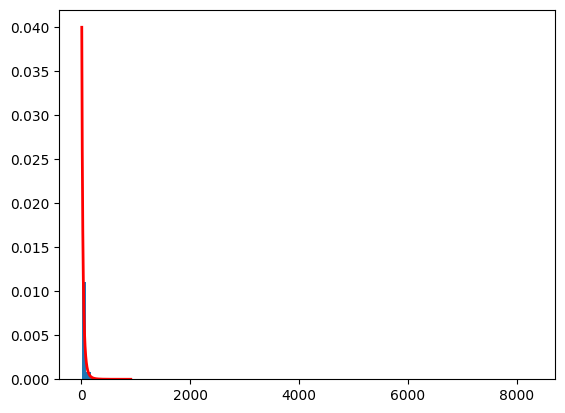

In [988]:
p2 = pareto2(loc=10,scale=100,shape=4)
test = p2.rvs(10000000)
loc=10
scale , shape = np.mean(test),np.std(test)
scale1, shape1 = (scale-loc)*(shape**2+(scale-loc)**2)/(shape**2-(scale-loc)**2),2*shape**2/(shape**2-(scale-loc)**2)
print(np.min(test),np.mean(test),np.std(test),np.max(test))

print(p2.mean(),p2.std())
print(scale1,shape1)

plt.hist(test, bins=100, density=True);
x=np.linspace(p2.ppf(0.0001),p2.ppf(0.9999),1000)
plt.plot(x,p2.pdf(x),color='red',lw=2)


# Quantile Gibbs

## posterior

In [4]:
import numpy as np
from scipy.stats import weibull_min, norm, cauchy, lognorm
from tqdm import tqdm

import numpy as np
from scipy.stats import cauchy, norm, gamma, weibull_min, gamma,lognorm,genpareto


def posterior(
    X,
    theta,
    distribution,
    prior_loc,
    prior_scale,
    prior_shape,
    par_prior_loc,
    par_prior_scale,
    par_prior_shape,
    std_prop_loc,
    std_prop_scale,
    std_prop_shape,
    reparametrization
):
    """Function to sample from the posterior of parameters theta given data X. 
    """ 
    # Special Normal/NIG case
    def post_NIG(X, par_prior_loc, par_prior_scale):
        mu_0, nu = par_prior_loc
        alpha, beta = par_prior_scale
        n = len(X)
        tau = np.random.gamma(
            shape=alpha + n / 2,
            scale=1
            / (
                beta
                + np.sum((X - np.mean(X)) ** 2) / 2
                + n * nu * (np.mean(X) - mu_0) ** 2 / (2 * (nu + n))
            ),
            size=1,
        )[0]
        mu = np.random.normal(
            loc=(nu * mu_0 + np.sum(X)) / (nu + n),
            scale=1 / np.sqrt((nu + n) * tau),
            size=1,
        )[0]
        return [mu, 1 / np.sqrt(tau),0]
    
    if distribution == "normal" and prior_loc == "NIG":
        return post_NIG(X, par_prior_loc, par_prior_scale)

    def llike_cauchy(x, loc, scale, shape,reparametrization=False):
        return np.sum(cauchy.logpdf(x, loc=loc, scale=scale))

    def llike_normal(x, loc, scale, shap,reparametrization=False):
        return np.sum(norm.logpdf(x, loc=loc, scale=scale))

    def llike_weibull(x, loc, scale, shape,reparametrization=False):
        return np.sum(weibull_min.logpdf(x, c=shape, scale=scale, loc=loc))
    def llike_lognormal(x,loc,scale,shape,reparametrization=True):
        if reparametrization: scale,shape = np.log((scale-loc)**2/np.sqrt((scale-loc)**2+shape**2)),np.sqrt(np.log(1+shape**2/(scale-loc)**2))
        return np.sum(lognorm.logpdf(x,loc=loc,s=shape,scale=np.exp(scale)))
    def llike_genpareto(x,loc,scale,shape,reparametrization=True):
        if reparametrization: scale,shape = (scale-loc)/2+(scale-loc)**3/(2*shape**2),1/2-(scale-loc)**2/(2*shape**2)
        return np.sum(genpareto.logpdf(x,c=shape,scale=scale,loc=loc))

    def llike_pareto2(x,loc,scale,shape,reparametrization=True):
        if reparametrization: scale, shape = (scale-loc)*(shape**2+(scale-loc)**2)/(shape**2-(scale-loc)**2),2*shape**2/(shape**2-(scale-loc)**2)
        return np.sum(pareto2(shape=shape,scale=scale,loc=loc).logpdf(x))

    def lprior_normal(x,par_prior):
        if par_prior[1]<=0:
            raise Exception(
                    "ERROR : prior parameter ({}) invalid for cauchy prior!".format(par_prior)
                )
        return norm(loc=par_prior[0], scale=par_prior[1]).logpdf(x)
    
    def lprior_cauchy(x,par_prior):
        if par_prior[1]<=0:
            raise Exception(
                    "ERROR : prior parameter ({}) invalid for cauchy prior!".format(par_prior)
                )
        return cauchy(loc=par_prior[0], scale=par_prior[1]).logpdf(x)

    def lprior_gamma(x,par_prior):
        if par_prior[0] <= 0 or par_prior[1]<=0:
            raise Exception(
                    "ERROR : prior parameter ({}) invalid for gamma prior!".format(par_prior)
                )
        return gamma(a=par_prior[0], scale=par_prior[1]).logpdf(x)
    
    def lprior_jeffreys(x,par_prior):
        return -np.log(x)
    
    
    loc, scale, shape = theta
    if distribution == "normal":
        llike = llike_normal
    elif distribution == "cauchy":
        llike = llike_cauchy
    elif distribution == "weibull":
        llike = llike_weibull
    elif distribution == "translated_weibull":
        llike = llike_weibull
    elif distribution == "lognormal" or distribution=="translated_lognormal":
        llike = llike_lognormal
    elif distribution == "generalized_pareto":
        llike = llike_genpareto
    elif distribution == "pareto2":
        llike = llike_pareto2
        
    else:
        raise Exception("ERROR : Distribution {} not valid !".format(distribution))

    # METROPOLIS HASTINGS STEP FOR LOCATION PARAMETER

    if distribution != "weibull" and distribution != "lognormal":        
        if prior_loc == "cauchy":
            lprior_loc = lprior_cauchy
        elif prior_loc == "normal":
            lprior_loc = lprior_normal
        elif prior_loc == "gamma":
            lprior_loc = lprior_gamma
            
        else:
            raise Exception(
                "ERROR : Prior for location {} not valid !".format(prior_loc)
            )
    

        loc_star = np.random.normal(loc, std_prop_loc)

        if not((loc_star >= np.min(X) and (distribution in ["translated_weibull","translated_lognormal","generalized_pareto","pareto2"]))):
            current_llike, candidate_llike = llike(X, loc, scale, shape,reparametrization), llike(
                X, loc_star, scale, shape,reparametrization
            )

            current_lprior, candidate_lprior = lprior_loc(loc,par_prior_loc), lprior_loc(loc_star,par_prior_loc)

            ratio_acceptation = min(
                np.exp(
                    candidate_llike - current_llike + candidate_lprior - current_lprior
                ),
                1,
            )
            #print("Loc: current = {} (prior = {} like = {}) candidate = {} (prior = {} like = {}) ratio = {}".format(loc,current_lprior,current_llike,loc_star,candidate_lprior,candidate_llike,ratio_acceptation))
            if np.random.uniform() < ratio_acceptation:
                loc = loc_star
                
    # METROPOLIS HASTINGS STEP FOR SCALE PARAMETER
    if prior_scale =="normal":
        lprior_scale = lprior_normal
    elif prior_scale == "gamma":
        lprior_scale = lprior_gamma
    elif prior_scale=="jeffreys":
        lprior_scale = lprior_jeffreys
        
    else:
        raise Exception("ERROR : Prior for scale {} not valid !".format(prior_scale))
    scale_star = np.random.normal(scale, std_prop_scale)

    if scale_star > 0:
        current_llike, candidate_llike = llike(X, loc, scale, shape, reparametrization), llike(
            X, loc, scale_star, shape, reparametrization
        )
        current_lprior, candidate_lprior = lprior_scale(scale,par_prior_scale), lprior_scale(scale_star,par_prior_scale)

        ratio_acceptation = min(
            np.exp(candidate_llike - current_llike + candidate_lprior - current_lprior),
            1,
        )
        #print("Scale: current = {} (prior = {} like = {}) candidate = {} (prior = {} like = {}) ratio = {}".format(scale,current_lprior,current_llike,scale_star,candidate_lprior,candidate_llike,ratio_acceptation))
        if np.random.uniform() < ratio_acceptation:
            scale = scale_star


    # METROPOLIS HASTINGS STEP FOR SHAPE PARAMETER

    if distribution in ["translated_weibull", "weibull","translated_lognormal","lognormal","generalized_pareto","pareto2"]:
        if prior_shape == "gamma":
            lprior_shape = lprior_gamma
        elif prior_shape == "normal":
            lprior_shape = lprior_normal
        elif prior_shape == "jeffreys":
            lprior_shape = lprior_jeffreys
        else:
            raise Exception(
                "ERROR : Prior for shape '{}' not valid !".format(prior_shape)
            )

        shape_star = np.random.normal(shape, std_prop_shape)

        if shape_star > -np.inf:
            current_llike, candidate_llike = llike(X, loc, scale, shape, reparametrization), llike(
                X, loc, scale, shape_star, reparametrization
            )

            current_lprior, candidate_lprior = lprior_shape(shape,par_prior_shape), lprior_shape(shape_star,par_prior_shape)
        
        
            ratio_acceptation = min(
                np.exp(
                    candidate_llike - current_llike + candidate_lprior - current_lprior
                ),
                1,
            )
            #print("Shape: current = {} (prior = {} like = {}) candidate = {} (prior = {} like = {}) ratio = {}".format(shape,current_lprior,current_llike,shape_star,candidate_lprior,candidate_llike,ratio_acceptation))
            if np.random.uniform() < ratio_acceptation:
                shape = shape_star
                
    return [loc, scale, shape]

## truncated

In [5]:
import numpy as np
from scipy.stats import norm,truncnorm,weibull_min,cauchy,lognorm,genpareto


def truncated(loc, scale, shape=1, a=-np.inf, b=np.inf, distribution="normal", size=1,reparametrization=True):
    """
    Function to sample from truncated distribution in interval [a,b].
    """
    #print("In truncated, theta = {}, {}, {} repar = {}".format(np.unique(loc),np.unique(scale),np.unique(shape),reparametrization))
    if distribution == "normal":
        res=truncnorm.rvs(a=(a-loc)/scale, b=(b-loc)/scale, loc=loc, scale=scale, size=size)

    else:
        if distribution=="weibull" or distribution=="lognormal":loc=0
        if distribution in ["translated_weibull","translated_lognormal","generalized_pareto"]:
            a=np.where(a<=loc,loc,a)
            b=np.where(b<=loc,loc,b)
        if distribution == "weibull" or distribution=="translated_weibull":
            law = weibull_min(c=shape, scale=scale, loc=loc)
        elif distribution=="generalized_pareto":
            #print("Avant in truncated",np.unique(loc),np.unique(scale),np.unique(shape))
            if reparametrization: scale,shape = (scale-loc)/2+(scale-loc)**3/(2*shape**2),1/2-(scale-loc)**2/(2*shape**2)
            #print("Apres in truncated",np.unique(loc),np.unique(scale),np.unique(shape))
            law = genpareto(loc=loc,scale=scale,c=shape)
        elif distribution=="translated_lognormal" or distribution=="lognormal":
            if reparametrization: scale,shape = np.log((scale-loc)**2/np.sqrt((scale-loc)**2+shape**2)),np.sqrt(np.log(1+shape**2/(scale-loc)**2))
            law = lognorm(s=shape,scale= np.exp(scale),loc=loc)
        elif distribution == "cauchy":
            law = cauchy(loc=loc, scale=scale)
        elif distribution == "pareto2":
            if reparametrization: scale, shape = (scale-loc)*(shape**2+(scale-loc)**2)/(shape**2-(scale-loc)**2),2*shape**2/(shape**2-(scale-loc)**2)
            law = pareto2(loc=loc, scale=scale, shape=shape)
        #print("In truncated, theta = {}, {}, {}".format(np.unique(loc),np.unique(scale),np.unique(shape)))
        #print("a,b = {}, {}".format(np.unique(a),np.unique(b)))
        ua,ub =law.cdf(a),law.cdf(b)
        #print("In truncated: ua= {}\nub = {}".format(np.unique(ua),np.unique(ub)))
        U = np.random.uniform(low=ua, high=ub, size=size)
        res = law.ppf(U)
    return res


def truncated_2inter(loc, scale, a, b, c, d, shape = 1, distribution="normal",size=1):
    """
    Function to sample from truncated distribution in the union of intervals [a,b] and [c,d].
    """
    if (a >= b) or (c >= d):
        print("a = {}, b = {}, c = {},d = {}".format(a, b, c, d))
    if distribution == "normal":
        F = norm(loc=loc, scale=scale).cdf
    elif distribution == "lognormal" or distribution=="translated_lognormal":
        F = lambda x :  norm.cdf((np.log(x)-loc)/scale)
    elif distribution == "cauchy":
        F = cauchy(loc=loc, scale=scale).cdf
    elif distribution == "translated_weibull" or distribution== "weibull":
        F= weibull_min(c=shape, scale=scale, loc=loc).cdf
        if scale<=0: print(loc,scale)
    elif distribution=="generalized_pareto":
        F = genpareto(loc=loc,scale=scale,c=shape).cdf
        
        
        
    if (b - loc) / scale <=  (a - loc) / scale : print((b - loc) / scale ,  (a - loc) / scale)
    if (
        F((b - loc) / scale)
        - F((a - loc) / scale)
        + F((d - loc) / scale)
        - F((c - loc) / scale)
    )<=0: return truncated(
            a=a,
            b=b,
            size=size,
            loc=loc,
            scale=scale,
            distribution=distribution
        )
    
    elif np.random.uniform(0, 1, 1) < (
        F((b - loc) / scale) - F((a - loc) / scale)
    ) / (
        F((b - loc) / scale)
        - F((a - loc) / scale)
        + F((d - loc) / scale)
        - F((c - loc) / scale)
    ):
        return truncated(
            a=a,
            b=b,
            size=size,
            loc=loc,
            scale=scale,
            distribution=distribution,
        )
    else:
        return truncated(
            a=c,
            b=d,
            size=size,
            loc=loc,
            scale=scale,
            distribution=distribution,
        )

## Quantile

In [27]:


def Quantile_Init(Q, P, N, distribution, epsilon=0.001,reparametrization=True):
    
    loc, scale, shape = 0, 1, 1
    if distribution == "normal":
        loc = Q[len(Q) // 2]
        scale = (Q[-1] - Q[0]) / (norm(loc).ppf(P[-1]) - norm(loc).ppf(P[0]))
        par_names = ["loc", "scale"]
    if distribution == "cauchy":
        loc = Q[len(Q) // 2]
        scale = (Q[-1] - Q[0]) / (cauchy(loc).ppf(P[-1]) - cauchy(loc).ppf(P[0]))
        par_names = ["loc", "scale"]
    if distribution == "translated_weibull" or distribution == "weibull":
        if distribution == "weibull":
            loc = 0
            par_names = ["scale", "shape"]

        else:
            loc = 2*Q[0]-Q[1]
            par_names = ["loc", "scale", "shape"]

        shape = 1.5
        scale = (Q[-1] - Q[0]) / (
            weibull_min(shape, loc=loc).ppf(P[-1])
            - weibull_min(shape, loc=loc).ppf(P[0])
        )
    if distribution == "translated_lognormal" or distribution == "lognormal":
        if distribution == "lognormal":
            loc = 0
            par_names = ["scale", "shape"]
        else:
            loc = 2*Q[0]-Q[1]
            par_names = ["loc", "scale", "shape"]
        shape = 1
        scale = np.log(Q[len(Q) // 2])
        print("Avant reparametrization",loc,scale,shape)
        if reparametrization: scale,shape = np.exp(scale+shape**2/2)+loc,np.sqrt(np.exp(shape**2)-1)*np.exp(scale+shape**2/2)
        print("Apres reparametrization",loc,scale,shape)
    if distribution == "generalized_pareto":
        loc = Q[0]-1
        shape = .1
        scale = (Q[-1] - Q[0]) / (
            genpareto(c=shape,loc=loc).ppf(P[-1])
            - genpareto(c=shape,loc=loc).ppf(P[0]))
        print("Avant reparametrization",loc,scale,shape)
        par_names = ["loc", "scale", "shape"]
        #loc,scale,shape=1500, 500,1/10
        if reparametrization: scale,shape = loc + scale /(1-shape),scale/((1-shape)*np.sqrt(1-2*shape))
        
        print("Après reparametrization",loc,scale,shape)
    if distribution == "pareto2":
        loc = Q[0]-1
        shape = 3
        scale = (Q[-1] - Q[0]) / (
            pareto2(shape=shape,loc=loc).ppf(P[-1])
            - pareto2(shape=shape,loc=loc).ppf(P[0]))
        print("Avant reparametrization",loc,scale,shape)
        par_names = ["loc", "scale", "shape"]
        if reparametrization: scale, shape = loc + scale /(shape-1),scale/(shape-1)*np.sqrt(shape/(shape-2))
        print("Après reparametrization",loc,scale,shape)
    init_theta = [loc, scale, shape]
    print("In Quantile_init : init_theta = {}".format(init_theta))
    H = np.array(P) * (N - 1) + 1
    I = np.floor(H)
    G = np.round(H - I, 8)
    Q_sim = []
    Q_tot = []
    K = []
    for k in range(len(G)):
        K.append(I[k])
        if G[k] == 0:
            Q_tot.append(Q[k])
        else:
            Q_sim.append(Q[k] - epsilon)
            Q_tot.append(Q[k] - epsilon)
            Q_tot.append((Q[k] - Q_tot[-1] * (1 - G[k])) / G[k])
            K.append(I[k] + 1)
            if k < len(G) - 1:
                if Q_tot[-1] > Q[k + 1]:
                    raise Exception("Initialization problem !")
    K = np.array(K)
    K1 = [K[0] - 1] + list(K[1:] - K[:-1] - 1) + [N - K[-1]]
    X1 = np.insert(np.array(Q_tot).astype(float), 0, -np.inf)

    X2 = np.append(Q_tot, np.inf)
    a, b = np.repeat(X1, K1), np.repeat(X2, K1)
    #print("Before truncated : loc = {}, scale = {}, shape = {}\na = {} b = {}".format(np.unique(loc),np.unique(scale),np.unique(shape),np.unique(a),np.unique(b)))
    
    sample = truncated(
        a=a,
        b=b,
        loc=np.repeat(loc, len(a)),
        scale=np.repeat(scale, len(a)),
        size=len(a),
        distribution=distribution,
        shape=shape,
        reparametrization=reparametrization
    )

    X_0 = np.round(np.append(sample, Q_tot).reshape(-1), 8)
    return X_0, init_theta, par_names, Q_sim, Q_tot, K, I, G


### RESAMPLING

def OrderStats_MH(Q_val, Q_sim, Q_tot, N, theta, K, I, G, distribution, std_prop,reparametrization=True):
    #print("In OrderStats_MH : theta = {}".format(theta))
    def log_density(X, I, loc, scale, distribution, shape=1,reparametrization = True):
        if distribution == "normal":
            f, F = norm(loc, scale).pdf, norm(loc, scale).cdf
        elif distribution == "cauchy":
            f, F = cauchy(loc, scale).pdf, cauchy(loc, scale).cdf
        elif distribution == "translated_weibull" or distribution == "weibull":
            f, F = (
                weibull_min(shape, loc=loc, scale=scale).pdf,
                weibull_min(shape, loc=loc, scale=scale).cdf,
            )
        elif distribution == "translated_lognormal" or distribution == "lognormal":
            if reparametrization: scale,shape = np.log((scale-loc)**2/np.sqrt((scale-loc)**2+shape**2)),np.sqrt(np.log(1+shape**2/(scale-loc)**2))
            f, F = (
                lognorm(s=shape, scale=np.exp(scale),loc=loc).pdf,
                lognorm(s=shape, scale=np.exp(scale),loc=loc).cdf,
            )
        elif distribution == "generalized_pareto":
            
            if reparametrization: 
                scale,shape = (scale-loc)/2+(scale-loc)**3/(2*shape**2),1/2-(scale-loc)**2/(2*shape**2)
            f, F = genpareto(loc=loc, scale=scale, c=shape).pdf, genpareto(loc=loc, scale=scale, c=shape).cdf
            
        elif distribution == "pareto2":
            if reparametrization: scale, shape = (scale-loc)*(shape**2+(scale-loc)**2)/(shape**2-(scale-loc)**2),2*shape**2/(shape**2-(scale-loc)**2)
            f, F = pareto2(loc=loc, scale=scale, shape=shape).pdf, pareto2(loc=loc, scale=scale, shape=shape).cdf
            
        # print(X)
        # print(F([X[1]]) - F(X[0]),F([X[3]]) - F(X[2]),f(X[2]),f(X[1]))
        # print(np.log(F([X[1]]) - F(X[0])),np.log(F([X[3]]) - F(X[2])),np.log(f(X[2])),np.log(f(X[1])))
        return (
            np.log(F([X[1]]) - F(X[0])) * (I[1] - I[0] - 1)
            + np.log(F([X[3]]) - F(X[2])) * (I[3] - I[2] - 1)
            + np.log(f(X[2]))
            + np.log(f(X[1]))
        )

    loc, scale, shape = theta
    if distribution == "normal":
        f, Q = norm(loc, scale).pdf, norm(loc, scale).ppf
    elif distribution == "cauchy":
        f, Q = cauchy(loc, scale).pdf, cauchy(loc, scale).ppf

    elif distribution == "translated_weibull" or distribution == "translated_weibull":
        f, Q = (
            weibull_min(shape, loc=loc, scale=scale).pdf,
            weibull_min(shape, loc=loc, scale=scale).ppf,
        )
    elif distribution=="generalized_pareto":
        if reparametrization: scale,shape = (scale-loc)/2+(scale-loc)**3/(2*shape**2),1/2-(scale-loc)**2/(2*shape**2)
        f, Q = genpareto(loc=loc, scale=scale, c=shape).pdf, genpareto(loc=loc, scale=scale, c=shape).ppf
    elif distribution == "translated_lognormal" or distribution == "lognormal":
        if reparametrization: scale,shape = np.log((scale-loc)**2/np.sqrt((scale-loc)**2+shape**2)),np.sqrt(np.log(1+shape**2/(scale-loc)**2))
        f, Q = (
            lognorm(s=shape, scale=np.exp(scale),loc=loc).pdf,
            lognorm(s=shape, scale=np.exp(scale),loc=loc).ppf,
        )
    elif distribution == "pareto2":
        if reparametrization: scale, shape = (scale-loc)*(shape**2+(scale-loc)**2)/(shape**2-(scale-loc)**2),2*shape**2/(shape**2-(scale-loc)**2)
        f, Q = pareto2(loc=loc, scale=scale, shape=shape).pdf, pareto2(loc=loc, scale=scale, shape=shape).ppf
        
    I_sim = np.array(I[np.where(G > 0)])
    p = I_sim / (N + 1)
    Var_K = p * (1 - p) / ((N + 2) * f(Q(p)) ** 2)
    Std_Kernel = std_prop * np.sqrt(Var_K) / (1 - G[np.where(G > 0)])
    Q_sim_star = np.random.normal(Q_sim[: len(Std_Kernel)], Std_Kernel)
    #print("len(Q_sim) = {} len(Q_sim_star) = {}".format(len(Q_sim),len(Q_sim_star)))

    Q_tot_star = []

    j = 0
    for i in range(len(Q_val)):
        if G[i] > 0:
            Q_tot_star.append(Q_sim_star[j])
            Q_tot_star.append((Q_val[i] - Q_sim_star[j] * (1 - G[i])) / G[i])
            j += 1
        else:
            Q_tot_star.append(Q_val[i])

    Q_tot_star2 = np.array(Q_tot_star)
    Q_tot_star2 = np.insert(Q_tot_star2, 0, -np.inf)
    Q_tot_star2 = np.append(Q_tot_star2, np.inf)
    Q_tot2 = np.array(Q_tot)
    Q_tot2 = np.insert(Q_tot2, 0, -np.inf)
    Q_tot2 = np.append(Q_tot2, np.inf)
    K1 = np.array(K)
    K1 = np.insert(K1, 0, 0)
    K1 = np.append(K1, N + 1)
    i = 0
    j = 1
    k = 0

    while j < len(Q_tot2) - 1:
        if k >= len(G):
            print(
                "ERREUR : k = ",
                k,
                " len(G) = ",
                len(G),
                "len(Q_sim*)=",
                len(Q_sim_star),
            )
        if G[k] > 0:
            if Q_sim_star[i] < Q_tot2[j - 1] or Q_sim_star[i] > Q_val[k]:
                j += 2
                i += 1
                k += 1
                #print("Q{} order problem!".format(k))
                continue
                
            

            X_current = Q_tot2[j - 1 : j + 3]
            X_candidate = [
                Q_tot2[j - 1],
                Q_tot_star2[j],
                Q_tot_star2[j + 1],
                Q_tot2[j + 2],
            ]
            I_i = K1[j - 1 : j + 3]
            log_density_current = log_density(
                X_current, I_i, loc, scale, distribution, shape=shape,reparametrization=reparametrization
            )
            log_density_candidate = log_density(
                X_candidate, I_i, loc, scale, distribution, shape=shape,reparametrization=reparametrization
            )
            ratio = np.exp(log_density_candidate - log_density_current)
        
            #print("Q{} : current = {} (llike = {}) candidate = {} (llike = {}) ratio = {}".format(k,Q_sim_star[i],log_density_current,Q_tot_star2[j],log_density_candidate,ratio))
            if np.random.uniform(0, 1) < ratio:
                Q_tot[j - 1] = Q_tot_star2[j]
                Q_tot[j] = Q_tot_star2[j + 1]
                Q_sim[i] = Q_tot_star2[j]
            j += 2
            i += 1
        else:
            j += 1
        k += 1
        #print()
    return Q_sim, Q_tot


def Resample_X_Q(
    Q_val, Q_sim, Q_tot, N, theta, K, I, G, distribution, std_prop, shape=1,reparametrization=True
):
    #print("In Resample_X_Q : theta = {}".format(theta))
    if len(Q_sim) > 0:
        Q_sim, Q_tot = OrderStats_MH(
            Q_val,
            Q_sim,
            Q_tot,
            N,
            theta,
            K,
            I,
            G,
            distribution,
            std_prop,
            reparametrization
        )
    loc, scale, shape = theta
    K1 = [K[0] - 1] + list(K[1:] - K[:-1] - 1) + [N - K[-1]]
    X1 = np.insert(np.array(Q_tot).astype(float), 0, -np.inf)
    X2 = np.append(Q_tot, np.inf)
    a, b = np.repeat(X1, K1), np.repeat(X2, K1)
    #print("In Resample_X_Q : theta = {} repar = {}".format([loc, scale, shape],reparametrization))
    sample = truncated(
        a=a,
        b=b,
        loc=np.repeat(loc, len(a)),
        scale=np.repeat(scale, len(a)),
        size=len(a),
        distribution=distribution,
        shape=np.repeat(shape, len(a)),
        reparametrization=reparametrization
    )
    return np.round(np.append(sample, Q_tot).reshape(-1), 8), Q_sim, Q_tot


### GIBBS SAMPLER
def llikelihood(X, theta, distribution,reparametrization=True):
    if distribution == "normal":
        return np.sum(norm(theta[0], theta[1]).logpdf(X))
    elif distribution == "cauchy":
        return np.sum(cauchy(theta[0], theta[1]).logpdf(X))
    elif distribution == "weibull":
        return np.sum(weibull_min(theta[2], theta[1]).logpdf(X))
    elif distribution == "translated_weibull":
        return np.sum(weibull_min(theta[2],loc=theta[0], scale=theta[1]).logpdf(X))
    elif distribution == "translated_lognormal" or distribution=="lognormal":
        loc,scale,shape = theta
        if reparametrization: scale,shape = np.log((scale-loc)**2/np.sqrt((scale-loc)**2+shape**2)),np.sqrt(np.log(1+shape**2/(scale-loc)**2))
        return np.sum(lognorm(s=shape, scale=np.exp(scale),loc=loc).logpdf(X))
    elif distribution == "generalized_pareto":
        loc,scale,shape = theta
        if reparametrization: scale,shape = (scale-loc)/2+(scale-loc)**3/(2*shape**2),1/2-(scale-loc)**2/(2*shape**2)
        return np.sum(genpareto(loc=loc, scale=scale, c=shape).logpdf(X))
    elif distribution == "pareto2":
        loc,scale,shape = theta
        if reparametrization: scale, shape = (scale-loc)*(shape**2+(scale-loc)**2)/(shape**2-(scale-loc)**2),2*shape**2/(shape**2-(scale-loc)**2)
        return np.sum(pareto2(shape=shape,scale=scale,loc=loc).logpdf(X))
    else:
        raise Exception("ERROR : Distribution {} in llikelihood not valid !".format(distribution))

def Gibbs_Quantile(
    T: int,
    N: int,
    Q: list,
    P: list,
    distribution: str = "normal",
    prior_loc: str = "normal",
    prior_scale: str = "gamma",
    prior_shape: str = "gamma",
    par_prior_loc: list = [0, 1],
    par_prior_scale: list = [0, 1],
    par_prior_shape: list = [0, 1],
    std_prop_loc: float = 0.1,
    std_prop_scale: float = 0.1,
    std_prop_shape: float = 0.1,
    std_prop_quantile=0.1,
    List_X=False,
    epsilon=0.001,
    verbose=True,
    True_X=[],
    reparametrization=False
):
    """Gibbs sampler to sample from the posterior of model parameters given a sequence of quantiles.

       Args:
        T (int): Number of iterations.
        N (int): Size of the vector X.
        Q (list): Observed quantile value.
        P (float): Probability associated to the observed quantiles Q.
        distribution (str): Distribution of the data ("normal", "cauchy", "weibull", or "translated_weibull").
        prior_loc (str): Prior distribution of the location parameter ("normal", "cauchy", "uniform", or "none").
        prior_scale (str): Prior distribution of the scale parameter ("gamma","jeffreys").
        prior_shape (str): Prior distribution of the shape parameter ("gamma").
        par_prior_loc (list, optional): Prior hyperparameters for the location parameter. Defaults to [0, 1].
        par_prior_scale (list, optional): Prior hyperparameters for the scale parameter. Defaults to [1, 1].
        par_prior_shape (list, optional): Prior hyperparameters for the shape parameter. Defaults to [0, 1].
        std_prop_loc (float, optional): Standard deviation of the RWMH Kernel for the location parameter. Defaults to 0.1.
        std_prop_scale (float, optional): Standard deviation of the RWMH Kernel for the scale parameter. Defaults to 0.1.
        std_prop_shape (float, optional): Standard deviation of the RWMH Kernel for the shape parameter. Defaults to 0.1.
        List_X (bool, optional): If True, will return the list of all latent vectors X. Otherwise, it will return the first and the last. Defaults to False.
        verbose (bool, optional): If True, will display the progression of the sampling. Defaults to True.
    Returns:
        A dictionary containing:
            chains (dict): The chains sampled from the parameters' posterior.
            X (list): List of latent vectors.
            Q_sim (list): List of all simulated order statistics at each iteration.
            Q_tot (list): List of all order statistics considered at each iteration.
            ... input parameters"""
    print("Init...")
    X, init_theta, par_names, q_sim, q_tot, K, I, G = Quantile_Init(
        Q, P, N, distribution, epsilon=epsilon,reparametrization=reparametrization
    )
    print("A supprimere : Init_theta = {} Qsim = {}".format(init_theta, q_sim))
    print(G,I)
    Theta = [init_theta]
    X_list = [X]
    Q_Tot = [q_tot]
    Q_Sim = [q_sim]
    Llike = [llikelihood(X, init_theta, distribution)]
    for i in tqdm(range(T), disable=not (verbose)):
        #print("GO for Sampling X and Q_sim...")
        #print("In Gibbs_Quantile : Iteration {} Reparametrization ≠ {}".format(i,reparametrization))
        if True_X==[]:
            X, q_sim, q_tot = Resample_X_Q(
            Q,
            q_sim,
            q_tot,
            N,
            Theta[-1],
            K,
            I,
            G,
            distribution,
            std_prop_quantile,
            reparametrization=reparametrization
        )
        else:
            X=True_X
            if i == 0 : 
                Theta[-1][0]=np.min(X)-epsilon
        #print("Go posterior sampling...")
        # plt.hist(X,bins=100,density=True);
        # for q in Q:
        #     plt.axvline(q,color="red")
        # plt.xlim(1000,5000)
        # plt.show()
        #print("Post resample Q_sim = {}".format(q_sim))
        theta = posterior(
            X,
            Theta[-1],
            distribution,
            prior_loc,
            prior_scale,
            prior_shape,
            par_prior_loc,
            par_prior_scale,
            par_prior_shape,
            std_prop_loc,
            std_prop_scale,
            std_prop_shape,
            reparametrization=reparametrization
        )
        #print("Posterior theta = {}\n\n".format(theta))
        Theta.append(theta)

        Q_Tot.append(list(q_tot))

        Q_Sim.append(list(q_sim))
        if List_X:
            X_list.append(X)
        Llike.append(llikelihood(X, theta, distribution,reparametrization))
    if not (List_X):
        X_list.append(X)

    if verbose:
        Q = np.array(Q_Sim).T
        print("I=", I, "Q.shape=", Q.shape)
        for i in range(Q.shape[0]):
            q = Q[i]
            print(
                "Acceptance rate of Q {} = {:.2%}".format(
                    i, (len(np.unique(q)) - 1) / len(q)
                )
            )
    Theta = np.array(Theta).T
    chains0 = {
        par_name: Theta[i] for i, par_name in enumerate(["loc", "scale", "shape"])
    }
    chains = {par_name: chains0[par_name] for par_name in par_names}
    if verbose and prior_loc != "NIG":
        acceptation_rate = [
            (len(np.unique(chains[par_name])) - 1) / T for par_name in par_names
        ]
        print("Acceptation rates MH :", end=" ")
        for i in range(len(par_names)):
            print("{} = {:.2%}".format(par_names[i], acceptation_rate[i]), end=" ")
        print()
    return {
        "X": X_list,
        "chains": chains,
        "N": N,
        "Q": Q,
        "P": P,
        "distribution": distribution,
        "prior_loc": prior_loc,
        "prior_scale": prior_scale,
        "prior_shape": prior_shape,
        "par_prior_loc": par_prior_loc,
        "par_prior_scale": par_prior_scale,
        "par_prior_shape": par_prior_shape,
        "Q_sim": np.array(Q_Sim),
        "Q_tot": np.array(Q_Tot),
        "T": T,
        "Llike": Llike,
    }


## display

In [7]:
def display(L_Gibbs,burnin=0,true_par=[]):
    if type(L_Gibbs)==dict:
        L_Gibbs=[L_Gibbs]
    f,ax=plt.subplots(2,3,figsize=(20,10))
    
    for Gibbs in L_Gibbs:
        sns.kdeplot(Gibbs["chains"]["loc"][burnin:],ax=ax[0,0])
        ax[1,0].plot(Gibbs["chains"]["loc"][burnin:])

        sns.kdeplot(Gibbs["chains"]["scale"][burnin:],ax=ax[0,1])
        ax[1,1].plot(Gibbs["chains"]["scale"][burnin:])
        sns.kdeplot(Gibbs["chains"]["shape"][burnin:],ax=ax[0,2])
        ax[1,2].plot(Gibbs["chains"]["shape"][burnin:])
    if true_par!=[]:
        ax[1,0].axhline(true_par[0],color="red")
        ax[0,0].axvline(true_par[0],color="red")   
        ax[1,1].axhline(true_par[1],color="red")
        ax[0,1].axvline(true_par[1],color="red")
        ax[1,2].axhline(true_par[2],color="red")
        ax[0,2].axvline(true_par[2],color="red")
    plt.show()

In [8]:
def display2(L_Gibbs,burnin=0,true_par=[]):
    if type(L_Gibbs)==dict:
        L_Gibbs=[L_Gibbs]
    f,ax=plt.subplots(2,2,figsize=(20,10))

    for Gibbs in L_Gibbs:
        sns.kdeplot(Gibbs["chains"]["scale"][burnin:],ax=ax[0,0])
        ax[1,0].plot(Gibbs["chains"]["scale"][burnin:])

        sns.kdeplot(Gibbs["chains"]["shape"][burnin:],ax=ax[0,1])
        ax[1,1].plot(Gibbs["chains"]["shape"][burnin:])

    if true_par!=[]:
        ax[1,0].axhline(true_par[0],color="red")
        ax[0,0].axvline(true_par[0],color="red")   
        ax[1,1].axhline(true_par[1],color="red")
        ax[0,1].axvline(true_par[1],color="red")
    plt.show()

# Import Data

In [9]:
filo=pd.read_csv('FILO2020_DISP_COM.csv',sep=';')
col=list(filo.columns)
for i in range(len(col)):
    col[i]=col[i].replace("20","")
print(col)
filo.rename(columns=dict(zip(filo.columns,col)),inplace=True)
filo.columns

/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


['CODGEO', 'NBMEN', 'NBPERS', 'NBUC', 'Q1', 'Q2', 'Q3', 'Q3_Q1', 'D1', 'D2', 'D3', 'D4', 'D6', 'D7', 'D8', 'D9', 'RD', 'S80S', 'GI', 'PACT', 'PTSA', 'PCHO', 'PBEN', 'PPEN', 'PPAT', 'PPSOC', 'PPFAM', 'PPMINI', 'PPLOGT', 'PIMPOT', 'AGE1Q1', 'AGE1Q2', 'AGE1Q3', 'AGE1Q3_Q1', 'AGE1D1', 'AGE1D2', 'AGE1D3', 'AGE1D4', 'AGE1D6', 'AGE1D7', 'AGE1D8', 'AGE1D9', 'AGE1RD', 'AGE1S80S', 'AGE1GI', 'AGE1PACT', 'AGE1PTSA', 'AGE1PCHO', 'AGE1PBEN', 'AGE1PPEN', 'AGE1PPAT', 'AGE1PPSOC', 'AGE1PPFAM', 'AGE1PPMINI', 'AGE1PPLOGT', 'AGE1PIMPOT', 'AGE2Q1', 'AGE2Q2', 'AGE2Q3', 'AGE2Q3_Q1', 'AGE2D1', 'AGE2D2', 'AGE2D3', 'AGE2D4', 'AGE2D6', 'AGE2D7', 'AGE2D8', 'AGE2D9', 'AGE2RD', 'AGE2S80S', 'AGE2GI', 'AGE2PACT', 'AGE2PTSA', 'AGE2PCHO', 'AGE2PBEN', 'AGE2PPEN', 'AGE2PPAT', 'AGE2PPSOC', 'AGE2PPFAM', 'AGE2PPMINI', 'AGE2PPLOGT', 'AGE2PIMPOT', 'AGE3Q1', 'AGE3Q2', 'AGE3Q3', 'AGE3Q3_Q1', 'AGE3D1', 'AGE3D2', 'AGE3D3', 'AGE3D4', 'AGE3D6', 'AGE3D7', 'AGE3D8', 'AGE3D9', 'AGE3RD', 'AGE3S80S', 'AGE3GI', 'AGE3PACT', 'AGE3PTSA', 'A

Index(['CODGEO', 'NBMEN', 'NBPERS', 'NBUC', 'Q1', 'Q2', 'Q3', 'Q3_Q1', 'D1',
       'D2',
       ...
       'OPR6PTSA', 'OPR6PCHO', 'OPR6PBEN', 'OPR6PPEN', 'OPR6PPAT', 'OPR6PPSOC',
       'OPR6PPFAM', 'OPR6PPMINI', 'OPR6PPLOGT', 'OPR6PIMPOT'],
      dtype='object', length=732)

In [11]:
codgeo = np.array(filo["CODGEO"]).astype(str)
codgeo

array(['1001', '1002', '1004', ..., '97422', '97423', '97424'],
      dtype='<U5')

# Contes

In [12]:
contes = filo.iloc[1917]

N_contes = int(contes["NBMEN"])
Q_contes = np.array(contes[["D1","D2","Q1","D3","D4","Q2","D6","D7","Q3","D8","D9"]]).astype(float)
P=np.array([.1,.2,.25,.3,.4,.5,.6,.7,.75,.8,.9])
N_contes,Q_contes


(2899,
 array([13510., 17170., 18640., 19870., 22320., 24290., 26500., 28840.,
        30220., 31960., 37720.]))

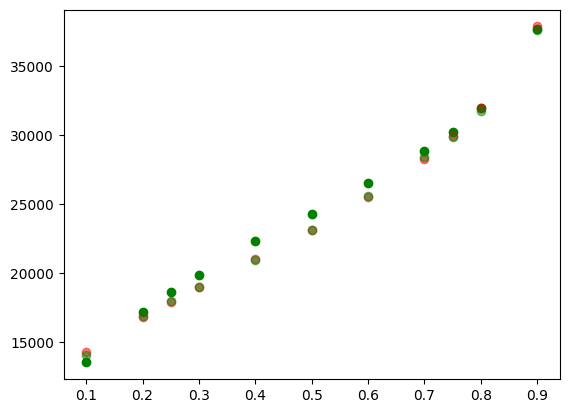

In [13]:
loc,scale,shape=1100,10.,.4
law = lognorm(s=shape, scale=np.exp(scale),loc=loc)

plt.scatter(P,Q_contes,color = "green")
#plt.plot(np.linspace(0,1,100),law.ppf(np.linspace(0,1,100)))
Q_test = law.ppf(P)
plt.scatter(P,Q_test,color="red",alpha=.5)
X_test = law.rvs(N_contes)
Q_empiric=np.quantile(X_test,P)
plt.scatter(P,Q_empiric,color="green",alpha=.5)



In [444]:
test_ln = Gibbs_Quantile(50000,3001,Q_contes,P,"translated_lognormal",
                         prior_loc="gamma",par_prior_loc=[10,1000],std_prop_loc=800,
                         prior_scale = "gamma",par_prior_scale=[3,5],std_prop_scale=.01,
                         prior_shape= "gamma",par_prior_shape=[1,1],std_prop_shape=.01,
                         std_prop_quantile=.01,verbose=True,epsilon=5,reparametrization=False,List_X=True)

Init...
Avant reparametrization 9850.0 10.097820021996219 1
Apres reparametrization 9850.0 10.097820021996219 1
In Quantile_init : init_theta = [9850.0, 10.097820021996219, 1]
A supprimere : Init_theta = [9850.0, 10.097820021996219, 1] Qsim = []
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [ 301.  601.  751.  901. 1201. 1501. 1801. 2101. 2251. 2401. 2701.]


  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [03:53<00:00, 214.09it/s]


I= [ 301.  601.  751.  901. 1201. 1501. 1801. 2101. 2251. 2401. 2701.] Q.shape= (0, 50001)
Acceptation rates MH : loc = 18.67% scale = 62.83% shape = 52.08% 


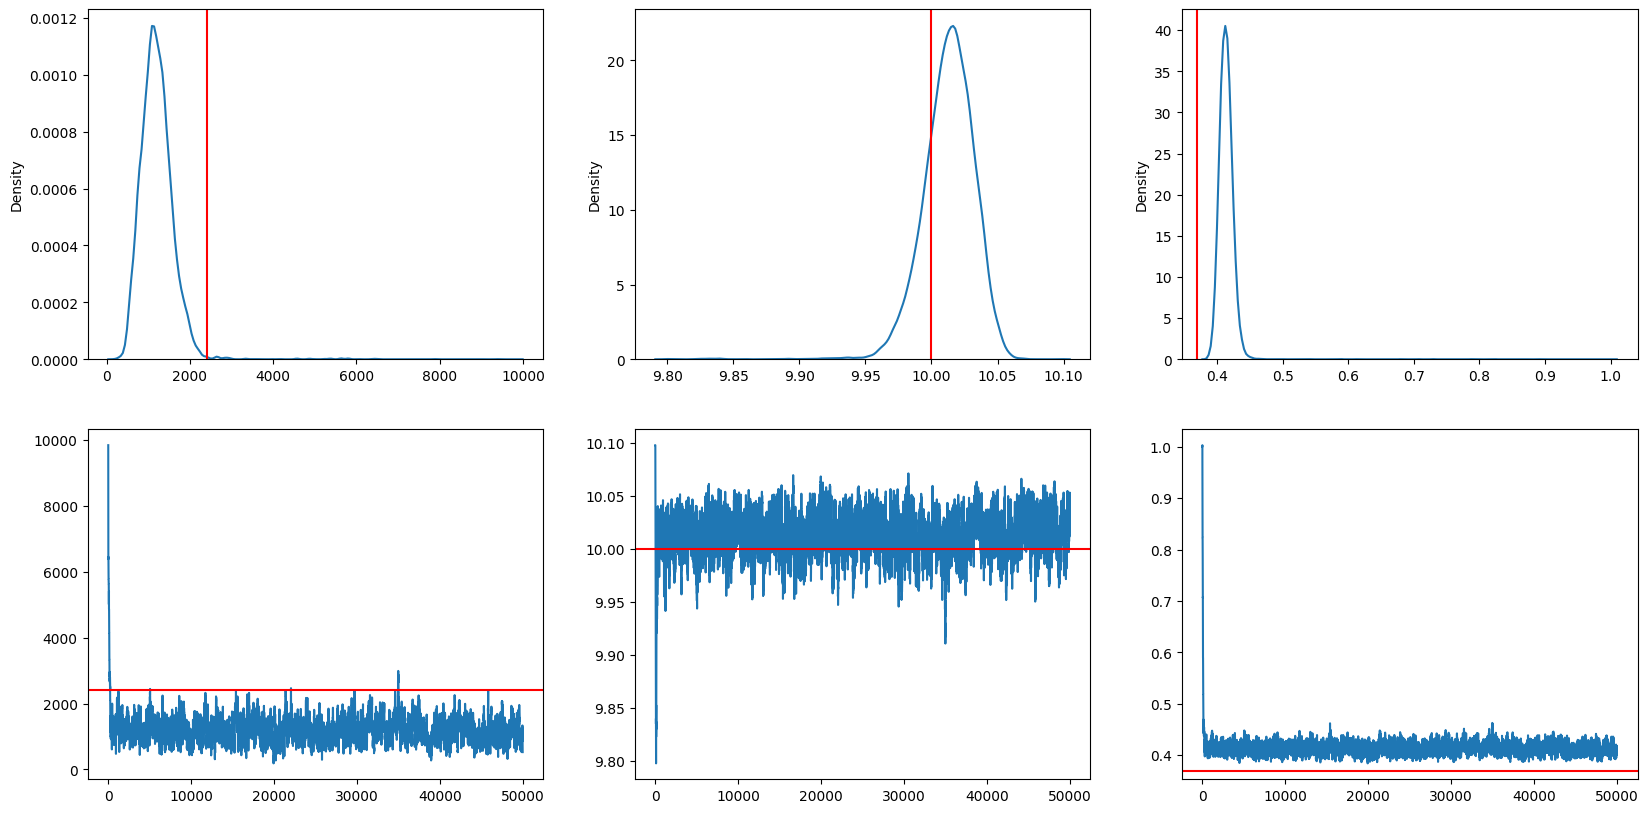

In [445]:
display(test_ln,burnin=0,true_par=[loc,scale,shape])

In [453]:
test_ln_repar = Gibbs_Quantile(50000,3001,Q_contes,P,"translated_lognormal",
                            prior_loc="gamma",par_prior_loc=[10,1000],std_prop_loc=800,
                            prior_scale = "gamma",par_prior_scale=[25,1000],std_prop_scale=200,
                            prior_shape= "gamma",par_prior_shape=[10,1000],std_prop_shape=200,
                            std_prop_quantile=.01,verbose=True,epsilon=5,reparametrization=True,List_X=True)

Init...
Avant reparametrization 9850.0 10.097820021996219 1
Apres reparametrization 9850.0 49897.439665306134 52495.48523209171
In Quantile_init : init_theta = [9850.0, 49897.439665306134, 52495.48523209171]
A supprimere : Init_theta = [9850.0, 49897.439665306134, 52495.48523209171] Qsim = []
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [ 301.  601.  751.  901. 1201. 1501. 1801. 2101. 2251. 2401. 2701.]


  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [03:57<00:00, 210.77it/s]


I= [ 301.  601.  751.  901. 1201. 1501. 1801. 2101. 2251. 2401. 2701.] Q.shape= (0, 50001)
Acceptation rates MH : loc = 39.98% scale = 61.39% shape = 60.65% 


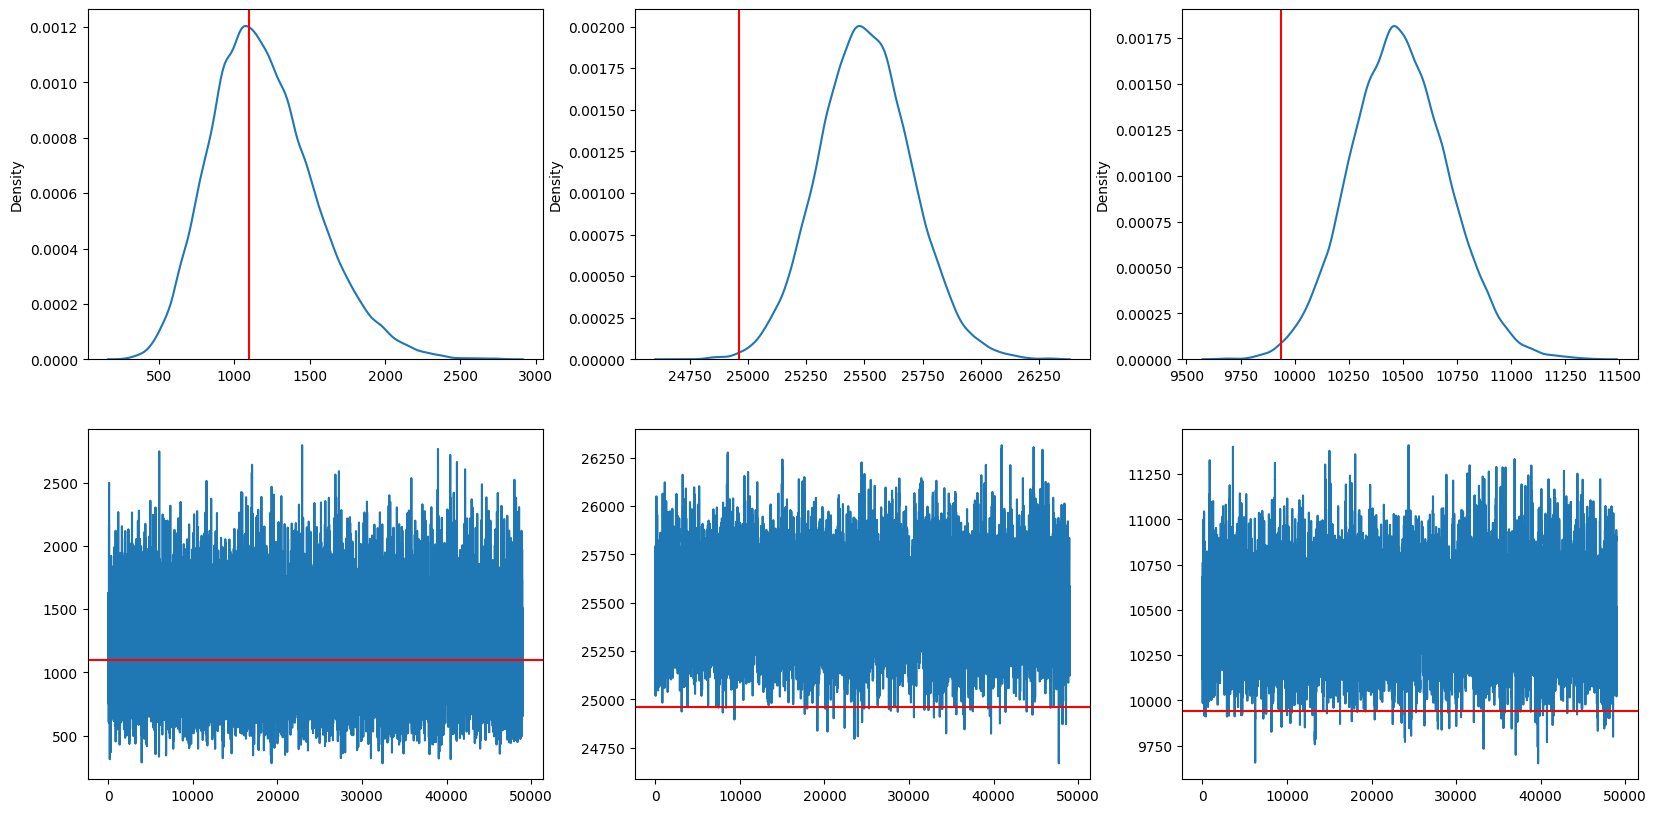

In [469]:
display(test_ln_repar,1000,true_par=[loc,law.mean(),law.std()])

In [468]:
test2_loc_ln = np.mean(test_ln_repar["chains"]["loc"][1000:])
test2_mean_ln = np.mean(test_ln_repar["chains"]["scale"][1000:])
test2_std_ln = np.mean(test_ln_repar["chains"]["shape"][1000:])
test2_scale_ln = np.log(test2_mean_ln**2/np.sqrt(test2_mean_ln**2+test2_std_ln**2))
test2_shape_ln = np.sqrt(np.log(1+test2_std_ln**2/test2_mean_ln**2))
test2_loc_ln,test2_scale_ln,test2_shape_ln

(1191.8777306177408, 10.06853538417003, 0.395146056092062)

For Lognorm non reparametrized :
loc = 1194.4326156856205 scale = 10.013475431011098 shape = 0.41345309506644906
mean = 25408.59062160505 std = 10460.087688519645

For lognorm reparametrized :
loc = 1191.8777306177408 scale = 10.06853538417003 shape = 0.395146056092062
mean = 25504.38270066032 std = 10484.452013667415


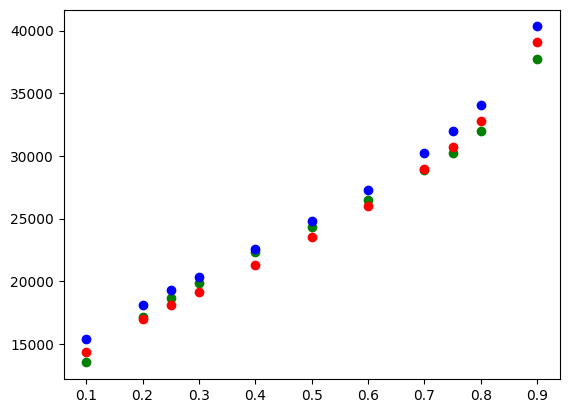

In [823]:
test_loc_ln = np.mean(test_ln["chains"]["loc"][10000:])
test_scale_ln = np.mean(test_ln["chains"]["scale"][10000:])
test_shape_ln = np.mean(test_ln["chains"]["shape"][10000:])

test_mean_ln = np.mean(lognorm(s=test_shape_ln, scale=np.exp(test_scale_ln),loc=test_loc_ln).rvs(10000))
test_std_ln = np.std(lognorm(s=test_shape_ln, scale=np.exp(test_scale_ln),loc=test_loc_ln).rvs(10000))
print("For Lognorm non reparametrized :\nloc = {} scale = {} shape = {}\nmean = {} std = {}".format(test_loc_ln,test_scale_ln,test_shape_ln,test_mean_ln,test_std_ln))
print("\nFor lognorm reparametrized :\nloc = {} scale = {} shape = {}\nmean = {} std = {}".format(test2_loc_ln,test2_scale_ln,test2_shape_ln,test2_mean_ln,test2_std_ln))
plt.scatter(P,Q_contes,color="green")
plt.scatter(P,lognorm(s=test_shape_ln, scale=np.exp(test_scale_ln),loc=test_loc_ln).ppf(P),color="red")
plt.scatter(P,lognorm(s=test2_shape_ln, scale=np.exp(test2_scale_ln),loc=test2_loc_ln).ppf(P),color="blue")

## Log-Normal

In [724]:
post_scale_ln,post_shape_ln

(10.013554063845593, 0.41309404902505414)

In [740]:
Contes_l = Gibbs_Quantile(50000,3001,Q_contes,P,"lognormal",
                            prior_scale = "gamma",par_prior_scale=[1,20],std_prop_scale=.01,
                            prior_shape= "gamma",par_prior_shape=[1,1],std_prop_shape=.01,
                            std_prop_quantile=.01,verbose=True,epsilon=1,reparametrization=False,List_X=True)

Init...
Avant reparametrization 0 10.097820021996219 1
Apres reparametrization 0 10.097820021996219 1
In Quantile_init : init_theta = [0, 10.097820021996219, 1]
A supprimere : Init_theta = [0, 10.097820021996219, 1] Qsim = []
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [ 301.  601.  751.  901. 1201. 1501. 1801. 2101. 2251. 2401. 2701.]


100%|██████████| 50000/50000 [03:03<00:00, 271.85it/s]


I= [ 301.  601.  751.  901. 1201. 1501. 1801. 2101. 2251. 2401. 2701.] Q.shape= (0, 50001)
Acceptation rates MH : scale = 61.02% shape = 49.87% 


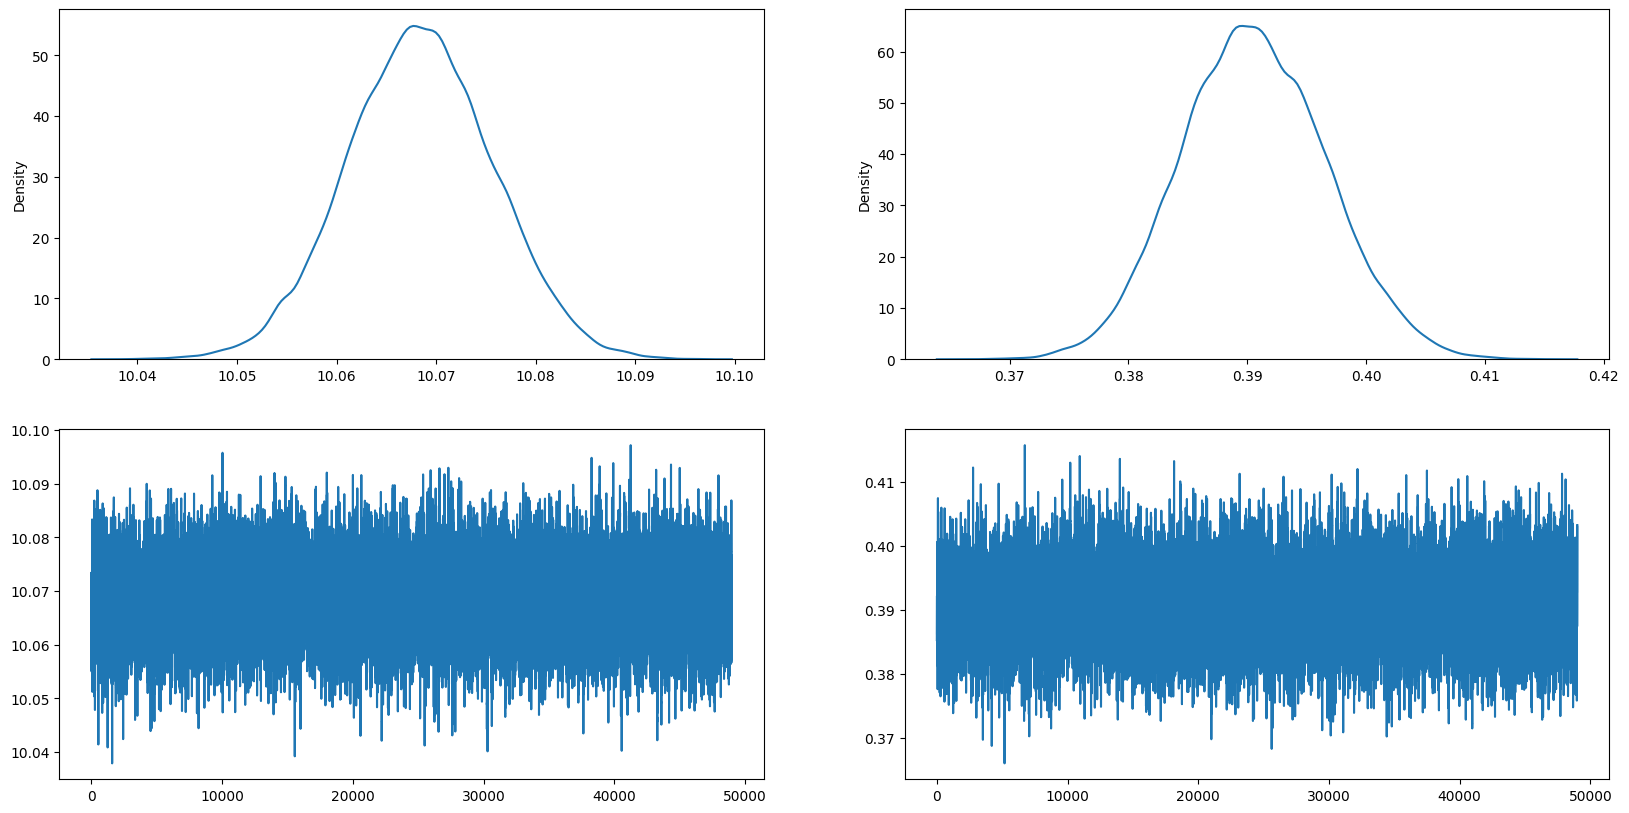

In [741]:
display2(Contes_l,1000)

In [742]:
burnin=1000
post_scale_l = np.mean(Contes_l["chains"]["scale"][burnin:])
post_shape_l = np.mean(Contes_l["chains"]["shape"][burnin:])


## Translated Log-normal

In [14]:
Contes_ln = Gibbs_Quantile(100000,3001,Q_contes,P,"translated_lognormal",
                            prior_loc="gamma",par_prior_loc=[10,1000],std_prop_loc=800,
                            prior_scale = "gamma",par_prior_scale=[25,1000],std_prop_scale=200,
                            prior_shape= "gamma",par_prior_shape=[10,1000],std_prop_shape=200,
                            std_prop_quantile=.01,verbose=True,epsilon=1,reparametrization=True,List_X=True)

Init...
Avant reparametrization 9850.0 10.097820021996219 1
Apres reparametrization 9850.0 49897.439665306134 52495.48523209171
In Quantile_init : init_theta = [9850.0, 49897.439665306134, 52495.48523209171]
A supprimere : Init_theta = [9850.0, 49897.439665306134, 52495.48523209171] Qsim = []
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [ 301.  601.  751.  901. 1201. 1501. 1801. 2101. 2251. 2401. 2701.]


  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [12:32<00:00, 132.92it/s]


I= [ 301.  601.  751.  901. 1201. 1501. 1801. 2101. 2251. 2401. 2701.] Q.shape= (0, 100001)
Acceptation rates MH : loc = 40.31% scale = 61.07% shape = 60.78% 


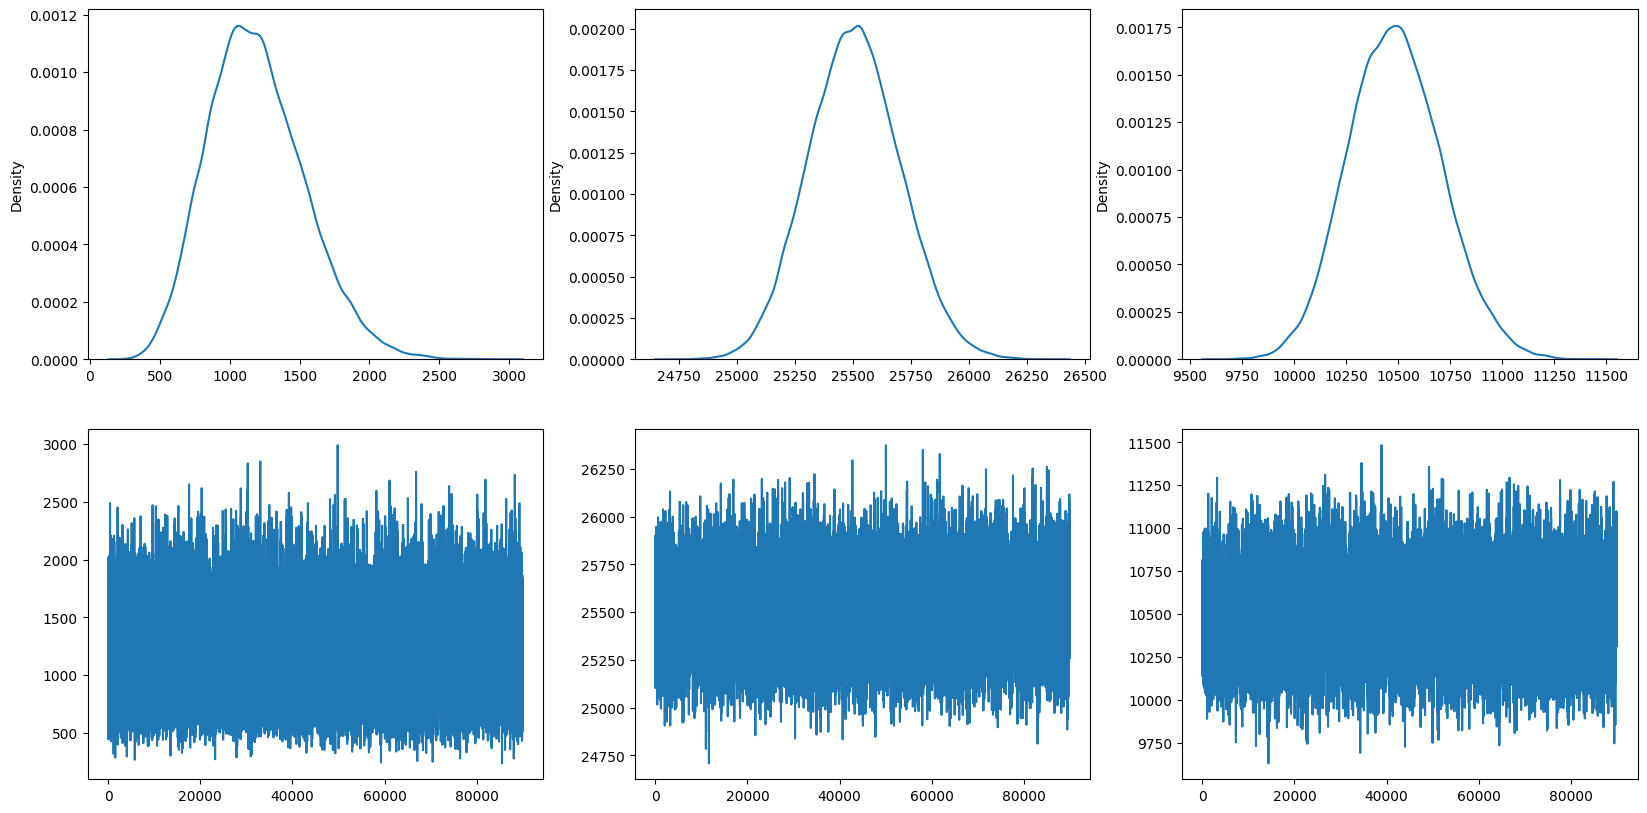

In [524]:
display(Contes_ln,10000)

In [24]:
burnin=10000
post_loc_ln = np.mean(Contes_ln["chains"]["loc"][burnin:])
post_mean_ln = np.mean(Contes_ln["chains"]["scale"][burnin:])
post_std_ln = np.mean(Contes_ln["chains"]["shape"][burnin:])
post_scale_ln = np.log((post_mean_ln - post_loc_ln)**2/np.sqrt((post_mean_ln - post_loc_ln)**2+post_std_ln**2))
post_shape_ln = np.sqrt(np.log(1+post_std_ln**2/(post_mean_ln - post_loc_ln)**2))


## Gen-Pareto

In [28]:
Contes_gp = Gibbs_Quantile(100000,3001,Q_contes,P,"generalized_pareto",
                            prior_loc="gamma",par_prior_loc=[10,1000],std_prop_loc=10,
                            prior_scale = "gamma",par_prior_scale=[25,1000],std_prop_scale=200,
                            prior_shape= "gamma",par_prior_shape=[10,1000],std_prop_shape=20,
                            std_prop_quantile=.01,verbose=True,epsilon=1,reparametrization=True,List_X=True)

Init...
Avant reparametrization 13509.0 9748.980441233685 0.1
Après reparametrization 13509.0 24341.200490259653 12110.768321063564
In Quantile_init : init_theta = [13509.0, 24341.200490259653, 12110.768321063564]
A supprimere : Init_theta = [13509.0, 24341.200490259653, 12110.768321063564] Qsim = []
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [ 301.  601.  751.  901. 1201. 1501. 1801. 2101. 2251. 2401. 2701.]


  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [11:19<00:00, 147.08it/s]


I= [ 301.  601.  751.  901. 1201. 1501. 1801. 2101. 2251. 2401. 2701.] Q.shape= (0, 100001)
Acceptation rates MH : loc = 44.20% scale = 18.29% shape = 48.76% 


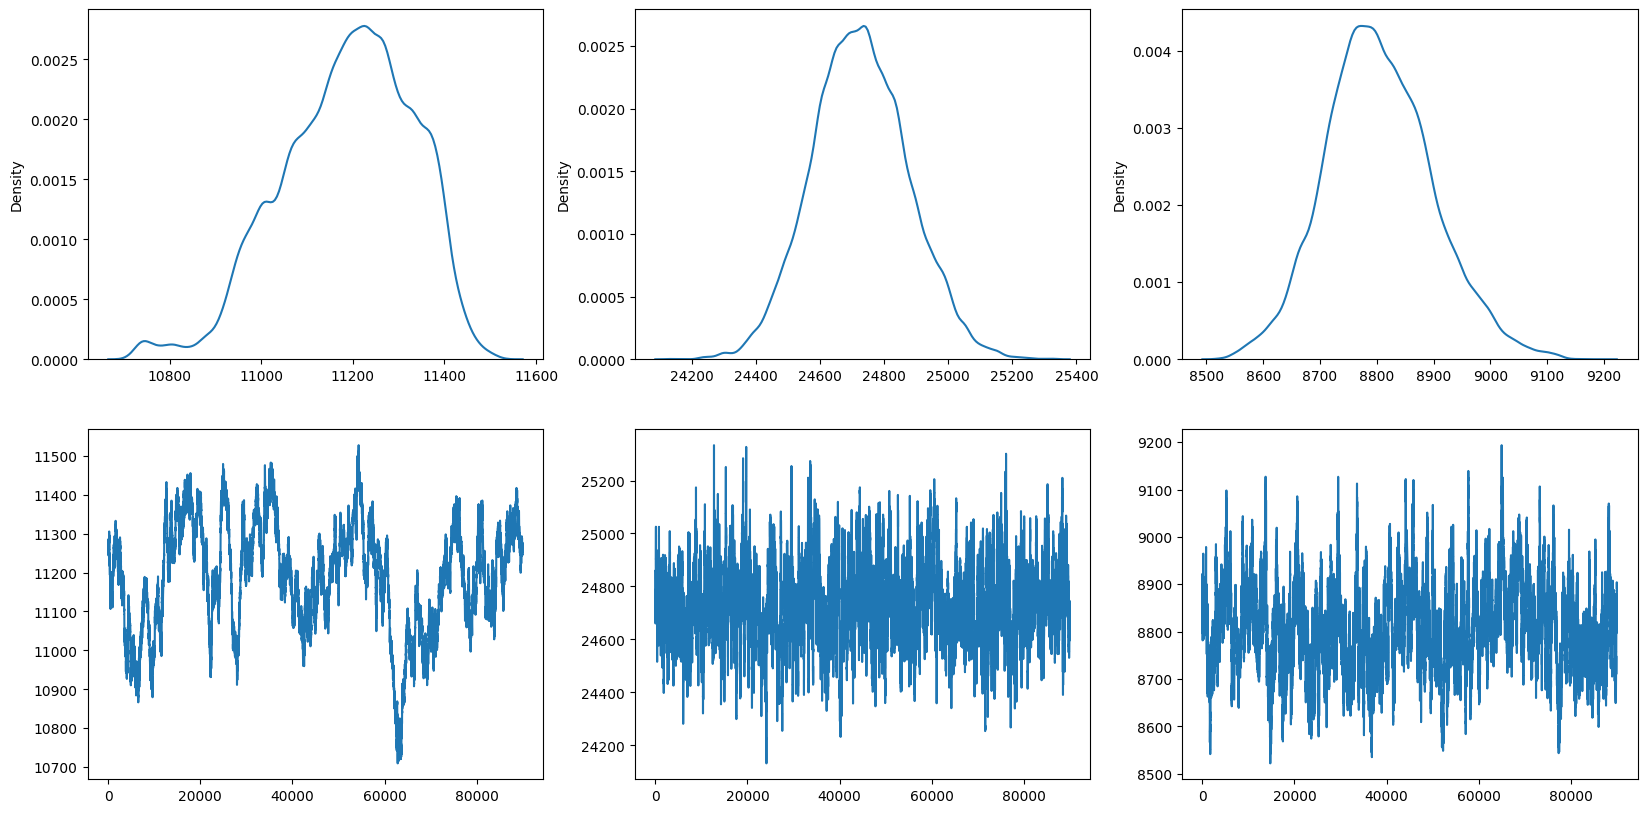

In [30]:
display(Contes_gp,10000)

In [53]:
burnin=10000

post_loc_gp = np.mean(Contes_gp["chains"]["loc"][burnin:])
post_mean_gp = np.mean(Contes_gp["chains"]["scale"][burnin:])
post_std_gp = np.mean(Contes_gp["chains"]["shape"][burnin:])
post_scale_gp = (post_mean_gp - post_loc_gp)/2+(post_mean_gp - post_loc_gp)**3/(2*post_std_gp**2)
post_shape_gp = 1/2-(post_mean_gp - post_loc_gp)**2/(2*post_std_gp**2)

print(post_loc_gp,post_scale_gp,post_shape_gp)

11188.210779374778 22770.22491349002 -0.6820211940000938


(24329.5, 18741.655763299037)

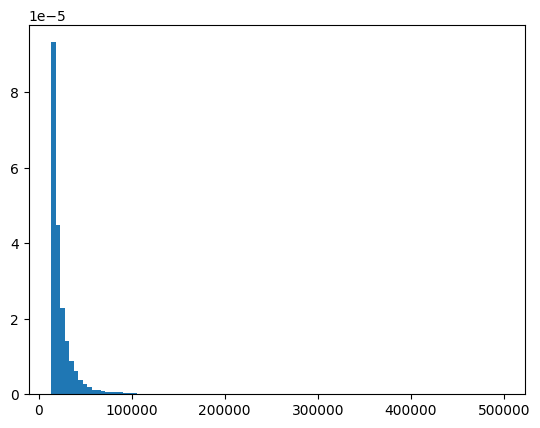

In [1028]:
p2 = pareto2(loc=13509,scale = 21641,shape=3)
test = p2.rvs(10000)
plt.hist(test,bins=100,density=True);
p2.mean(),p2.std()

## Pareto type II

In [15]:
Contes_p2 = Gibbs_Quantile(100000,3001,Q_contes,P, "pareto2",
                            prior_loc="gamma",par_prior_loc=[10,1000],std_prop_loc=10,
                            prior_scale = "gamma",par_prior_scale=[25,1000],std_prop_scale=150,
                            prior_shape= "gamma",par_prior_shape=[10,1000],std_prop_shape=100,
                            std_prop_quantile=.01,verbose=True,epsilon=1,reparametrization=True,List_X=True)

Init...
Avant reparametrization 13509.0 21641.37403268331 3
Après reparametrization 13509.0 24329.687016341653 18741.979685104627
In Quantile_init : init_theta = [13509.0, 24329.687016341653, 18741.979685104627]
A supprimere : Init_theta = [13509.0, 24329.687016341653, 18741.979685104627] Qsim = []
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [ 301.  601.  751.  901. 1201. 1501. 1801. 2101. 2251. 2401. 2701.]


  0%|          | 79/100000 [00:00<06:29, 256.65it/s]/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  
100%|██████████| 100000/100000 [06:54<00:00, 241.40it/s]


I= [ 301.  601.  751.  901. 1201. 1501. 1801. 2101. 2251. 2401. 2701.] Q.shape= (0, 100001)
Acceptation rates MH : loc = 32.23% scale = 15.51% shape = 22.10% 


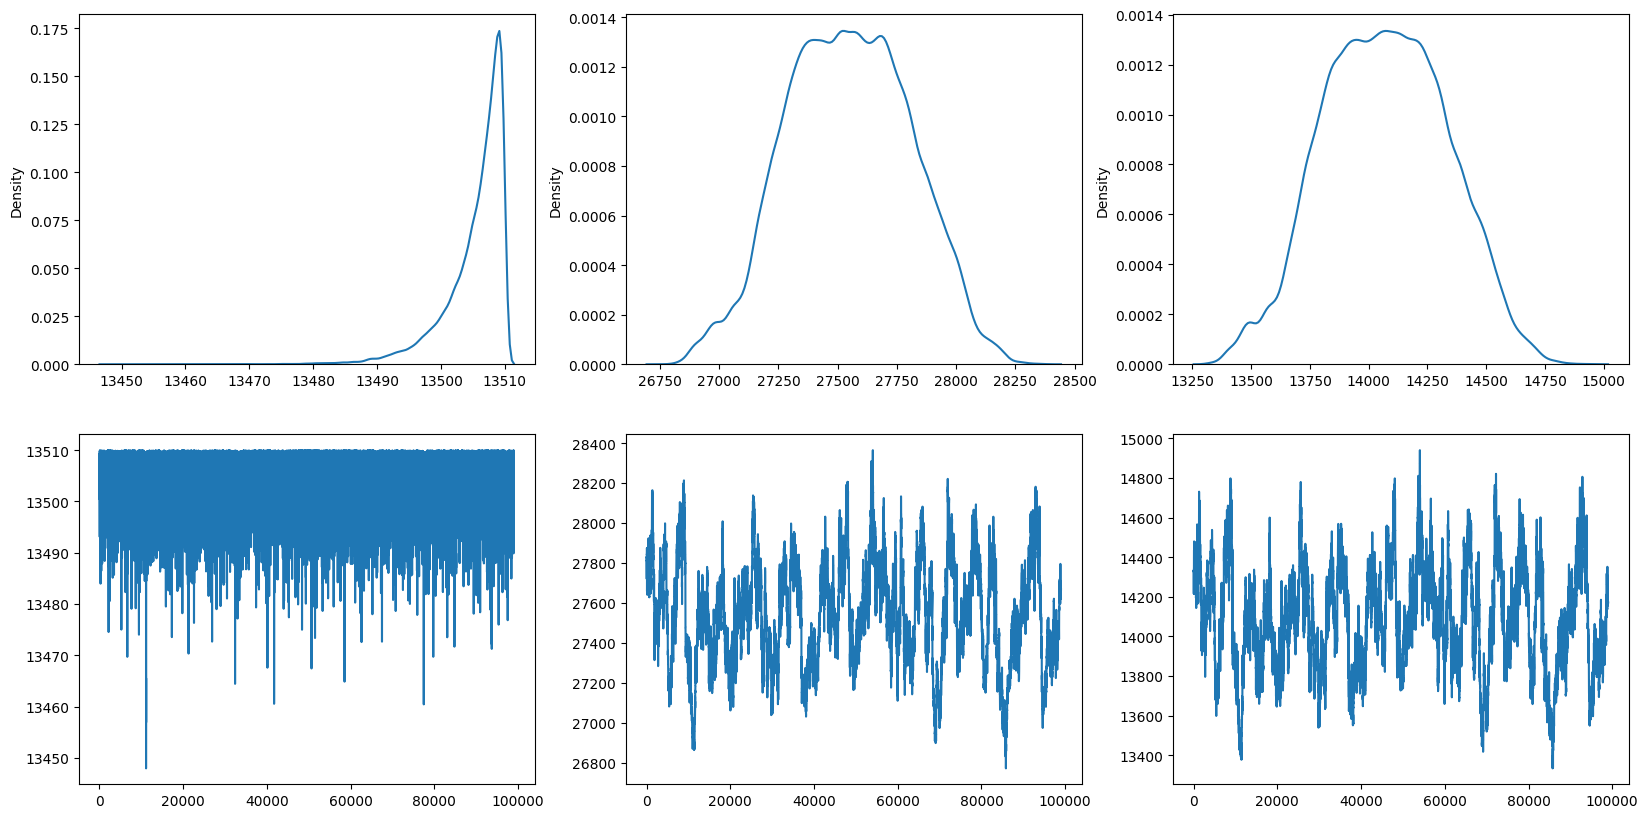

In [1040]:
display(Contes_p2,1000)

In [17]:
post_loc_p2, post_mean_p2, post_std_p2 = Contes_p2["chains"]["loc"][1000:], Contes_p2["chains"]["scale"][1000:], Contes_p2["chains"]["shape"][1000:]
post_scale_p2, post_shape_p2 = (post_mean_p2 - post_loc_p2)*(post_std_p2**2+(post_mean_p2 - post_loc_p2)**2)/(post_std_p2**2-(post_mean_p2 - post_loc_p2)**2), 2*post_std_p2**2/(post_std_p2**2-(post_mean_p2 - post_loc_p2)**2)

post_loc_p2, post_scale_p2, post_shape_p2 , post_mean_p2, post_std_p2 = np.mean(post_loc_p2), np.mean(post_scale_p2), np.mean(post_shape_p2), np.mean(post_mean_p2), np.mean(post_std_p2)
print(post_loc_p2, post_scale_p2, post_shape_p2 , post_mean_p2, post_std_p2)

13505.266097472555 61063558.24620641 4334.392367761704 27604.239543372376 14128.924005168992


## Weibull

In [20]:
Contes_tw = Gibbs_Quantile(100000,3001,Q_contes,P, "translated_weibull",
                           prior_loc="gamma",par_prior_loc= [1,10000],std_prop_loc=500,
                           prior_scale = "gamma",par_prior_scale=[2,10000],std_prop_scale = 1000,
                           prior_shape="gamma",par_prior_shape=[1,10],std_prop_shape= .1,
                           std_prop_quantile=.1,epsilon=1,verbose=True,List_X=True,reparametrization=False)

Init...
In Quantile_init : init_theta = [9850.0, 15920.865337298015, 1.5]
A supprimere : Init_theta = [9850.0, 15920.865337298015, 1.5] Qsim = []
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [ 301.  601.  751.  901. 1201. 1501. 1801. 2101. 2251. 2401. 2701.]


100%|██████████| 100000/100000 [10:10<00:00, 163.76it/s]


I= [ 301.  601.  751.  901. 1201. 1501. 1801. 2101. 2251. 2401. 2701.] Q.shape= (0, 100001)
Acceptation rates MH : loc = 30.62% scale = 21.39% shape = 36.06% 


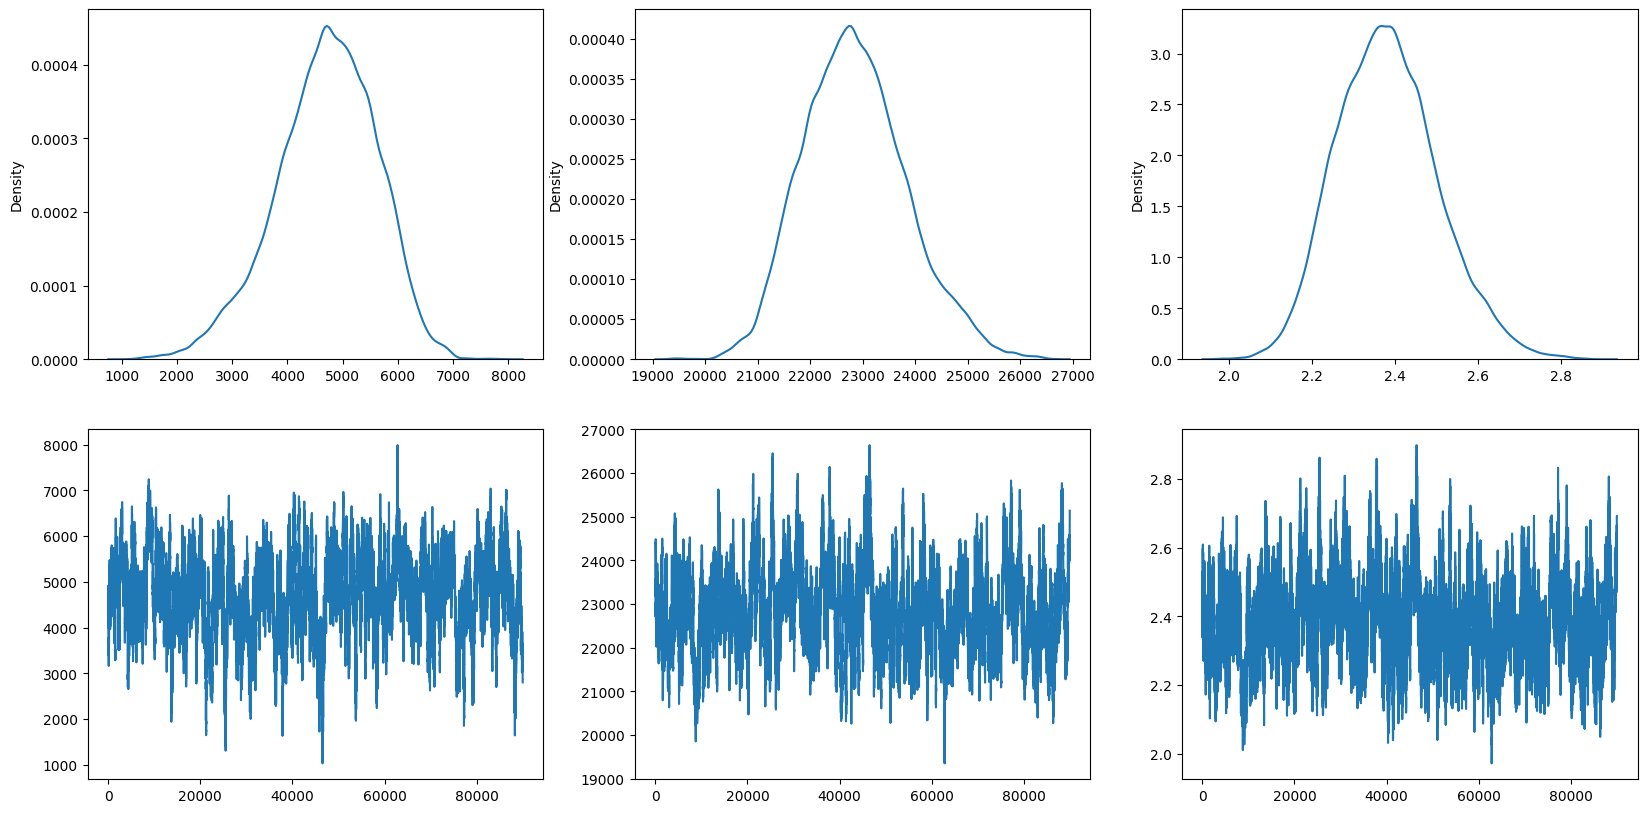

In [22]:
display(Contes_tw,10000)

In [33]:
post_loc_tw = np.mean(Contes_tw["chains"]["loc"][burnin:])
post_scale_tw = np.mean(Contes_tw["chains"]["scale"][burnin:])
post_shape_tw = np.mean(Contes_tw["chains"]["shape"][burnin:])

law_tw = weibull_min(c=post_shape_tw, scale=post_scale_tw,loc=post_loc_tw)

print(post_loc_tw,post_scale_tw,post_shape_tw)

4708.395661946991 22858.40083761542 2.381646215145841


## Comparaison

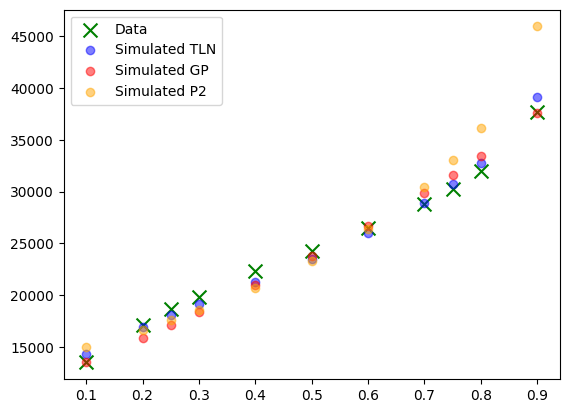

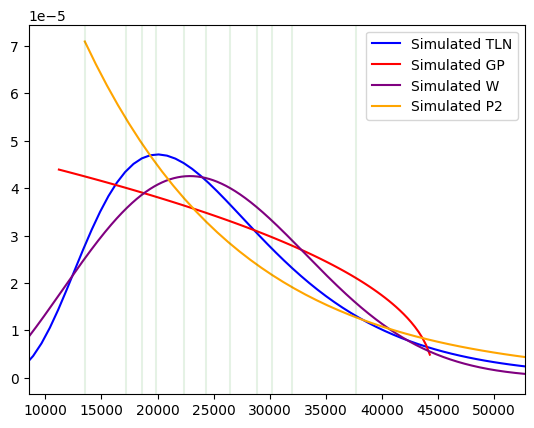

In [35]:
plt.scatter(P,Q_contes,color="green",label = "Data",marker="x",s=100)
# law_l = lognorm(s = post_shape_l,scale = np.exp(post_scale_l))
# plt.scatter(P,law_l.ppf(P),color="red",label = "Lognormal",marker="+")
law_ln = lognorm(s=post_shape_ln, scale=np.exp(post_scale_ln),loc=post_loc_ln)
law_gp = genpareto(c=post_shape_gp, scale=post_scale_gp,loc = post_loc_gp)
plt.scatter(P,law_ln.ppf(P),label="Simulated TLN",alpha=.5,color="blue")
plt.scatter(P,law_gp.ppf(P),label = "Simulated GP",alpha=.5,color="RED")
#law_tw = weibull_min(c=post_shape_tw, scale=post_scale_tw,loc=post_loc_tw)
#plt.scatter(P,law_tw.ppf(P),label = "Simulated W",alpha=.5,color="purple")
law_p2 = pareto2(shape=post_shape_p2,scale=post_scale_p2,loc=post_loc_p2)
plt.scatter(P,law_p2.ppf(P),label = "Simulated P2",alpha=.5,color="orange")
#plt.scatter(P,law_p.ppf(P),label = "Simulated P",alpha=.5,color="red")
plt.legend()
plt.show()

# x=np.linspace(law_l.ppf(.001),law_l.ppf(.999),100) 
# plt.plot(x,law_l.pdf(x),label="Simulated LN")

x=np.linspace(law_ln.ppf(.001),law_ln.ppf(.999),100) 
plt.plot(x,law_ln.pdf(x),label="Simulated TLN",color="blue")
x=np.linspace(law_gp.ppf(.001),law_gp.ppf(.999),100)
plt.plot(x,law_gp.pdf(x),label="Simulated GP",color="RED")
# x=np.linspace(law_p.ppf(.001),law_p.ppf(.999),1000)
#plt.plot(x,law_p.pdf(x),label="Simulated P",color="red")
x=np.linspace(law_tw.ppf(.001),law_tw.ppf(.999),1000)
plt.plot(x,law_tw.pdf(x),label="Simulated W",color="purple")
x = np.linspace(law_p2.ppf(.001),law_p2.ppf(.999),100)
plt.plot(x,law_p2.pdf(x),label="Simulated P2",color="orange")
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.1)
plt.legend()
plt.xlim(Q_contes[0]-5000,Q_contes[-1]+15000)
plt.show()


In [36]:
post_loc_ln,post_mean_ln,post_std_ln,post_scale_ln,post_shape_ln

(1195.6914422772284,
 25510.052179272563,
 10492.65312127582,
 10.013433179865228,
 0.4132535583306154)

In [37]:
post_loc_gp,post_mean_gp,post_std_gp,post_scale_gp,post_shape_gp

(11188.210779374778,
 24725.629329576917,
 8804.571548124099,
 22770.22491349002,
 -0.6820211940000938)

# Bayes Factor

In [ ]:
from tqdm import tqdm

In [38]:
def BF_Bridge_Quantile(y1,y2,theta1,theta2,llike1,llike2,BF_init=1,epsilon=.001,n=100):
    BF = [0,BF_init]
    if np.ndim(y1)==1:y1= np.repeat(y1,theta1.shape[0]).reshape(-1,theta1.shape[0]).T
    if np.ndim(y2)==1:y2= np.repeat(y2,theta2.shape[0]).reshape(-1,theta2.shape[0]).T
    k=0
    # p11=[llike1(y1[i],theta1[i]) for i in tqdm(range(theta1.shape[0]))]
    # p21=[llike2(y1[i],theta1[i]) for i in tqdm(range(theta1.shape[0]))]
    # p12=[llike1(y2[i],theta2[i]) for i in tqdm(range(theta2.shape[0]))]
    # p22=[llike2(y2[i],theta2[i]) for i in tqdm(range(theta2.shape[0]))]
    # print("Mean llike1(y1|theta1) = {} Mean llike2(y1|theta1) = {}".format(np.mean(p11),np.mean(p21)))
    # print("Mean llike1(y2|theta2) = {} Mean llike2(y2|theta2) = {}".format(np.mean(p12),np.mean(p22)))
    while np.abs(BF[-1]-BF[-2])>epsilon and (k+1)*n<theta1.shape[0]:
        p22 = [llike2(y2[i],theta2[i]) for i in range(k*n,(k+1)*n)]
        p12 = [llike1(y2[i],theta2[i]) for i in range(k*n,(k+1)*n)]
        p21 = [llike2(y1[i],theta1[i]) for i in range(k*n,(k+1)*n)]
        p11 = [llike1(y1[i],theta1[i]) for i in range(k*n,(k+1)*n)]
        print("{}. Mean llike1(y1|theta1) = {} Mean llike2(y1|theta1) = {}".format(k+1,np.mean(p11),np.mean(p21)))
        print("{}. Mean llike1(y2|theta2) = {} Mean llike2(y2|theta2) = {}".format(k+1,np.mean(p12),np.mean(p22)))
        
        numerator = np.sum([1/(1+np.exp(llike2(y2[i],theta2[i])-llike1(y2[i],theta2[i]))*BF[-1]) for i in range(k*n,(k+1)*n)])
        denominator = np.sum([1/(np.exp(llike1(y1[i],theta1[i])-llike2(y1[i],theta1[i]))+BF[-1]) for i in range(k*n,(k+1)*n)])
        new_BF = numerator/denominator
        print("{}. Numerator = {:.2E} Denominator = {:.2E} BF = {}".format(k+1,numerator, denominator, new_BF))
        BF.append(new_BF)
        k+=1
    return BF[1:]

In [39]:
def llike_pareto2(y, par):
    loc, mean, std = par
    scale,shape = (mean-loc)*(std**2+(mean-loc)**2)/(std**2-(mean-loc)**2),2*std**2/(std**2-(mean-loc)**2)
    
    return np.sum(pareto2(loc=loc, scale=scale, shape=shape).logpdf(y))

In [40]:
def llike_genpareto(y,par):
    loc, mean, std = par
    scale,shape = (mean-loc)/2+(mean-loc)**3/(2*std**2),1/2-(mean-loc)**2/(2*std**2)
    return np.sum(genpareto(loc=loc,scale=scale,c=shape).logpdf(y))

In [41]:
def llike_lognormal(y, par):
    loc, mean, std = par
    scale,shape = np.log((mean-loc)**2/np.sqrt((mean-loc)**2+std**2)),np.sqrt(np.log(1+std**2/(mean-loc)**2))
    return np.sum(lognorm(s=shape, scale=np.exp(scale), loc=loc).logpdf(y))


In [56]:
burnin =10000
theta_ln = np.array([Contes_ln["chains"]["loc"], Contes_ln["chains"]["scale"], Contes_ln["chains"]["shape"]]).T[burnin:]
theta_gp = np.array([Contes_gp["chains"]["loc"], Contes_gp["chains"]["scale"], Contes_gp["chains"]["shape"]]).T[burnin:]
theta_p2 = np.array([Contes_p2["chains"]["loc"], Contes_p2["chains"]["scale"], Contes_p2["chains"]["shape"]]).T[burnin:]
Y_ln = np.array(Contes_ln["X"][burnin:])
Y_gp = np.array(Contes_gp["X"][burnin:])
Y_p2 = np.array(Contes_p2["X"][burnin:])

print("Shapes : theta_ln = {} theta_gp = {} Y_ln = {} Y_gp = {}".format(theta_ln.shape,theta_gp.shape,Y_ln.shape,Y_gp.shape))

Shapes : theta_ln = (90001, 3) theta_gp = (90001, 3) Y_ln = (90001, 3001) Y_gp = (90001, 3001)


In [1067]:
Y_p2.shape

(90001, 3001)

In [1068]:
theta_p2.shape

(90001, 3)

1165.263813446751 79074.25510602815 -2.2629390140369523
11260.727540087837 22561.134465078165 -0.6763085706454068


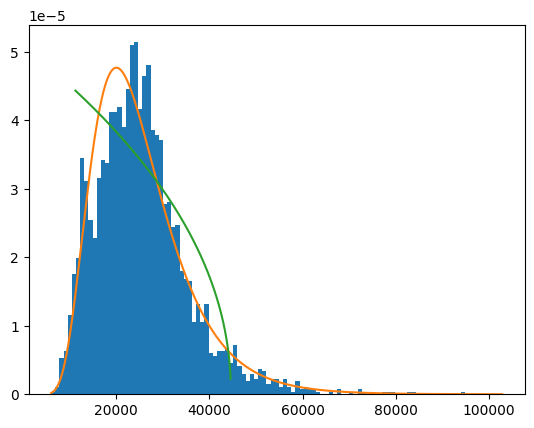

In [566]:
plt.hist(Y_ln[0],bins=100,density=True);
loc_ln,mean_ln,std_ln = theta_ln[0]
scale_ln,shape_ln = np.log((mean_ln - loc_ln)**2/np.sqrt((mean_ln - loc_ln)**2+std_ln**2)),np.sqrt(np.log(1+std_ln**2/(mean_ln - loc_ln)**2))
law_ln=lognorm(s=shape_ln, scale=np.exp(scale_ln),loc=loc_ln)
x=np.linspace(law_ln.ppf(.0001),law_ln.ppf(.9999),1000)
plt.plot(x,law_ln.pdf(x))
loc_gp,mean_gp,std_gp = theta_ln[0]
scale_gp,shape_gp = (mean_gp - loc_gp)/2+(mean_gp - loc_gp)**3/(2*std_gp**2),1/2-(mean_gp - loc_gp)**2/(2*std_gp**2)
law_gp=genpareto(loc=post_loc_gp,scale=post_scale_gp,c=post_shape_gp)
print(loc_gp,scale_gp,shape_gp)
print(post_loc_gp,post_scale_gp,post_shape_gp)
x=np.linspace(law_gp.ppf(.0001),law_gp.ppf(.9999),1000)
plt.plot(x,law_gp.pdf(x))

In [562]:
post_shape_gp

-0.6763085706454068

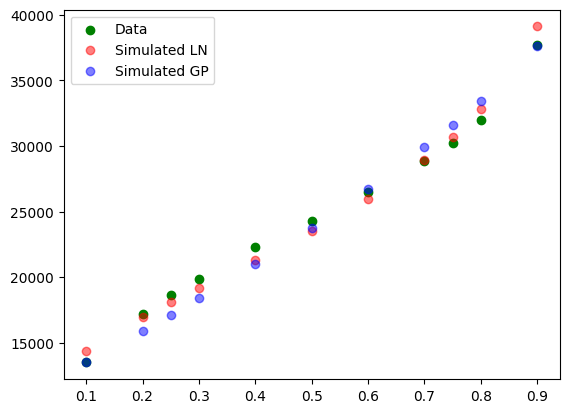

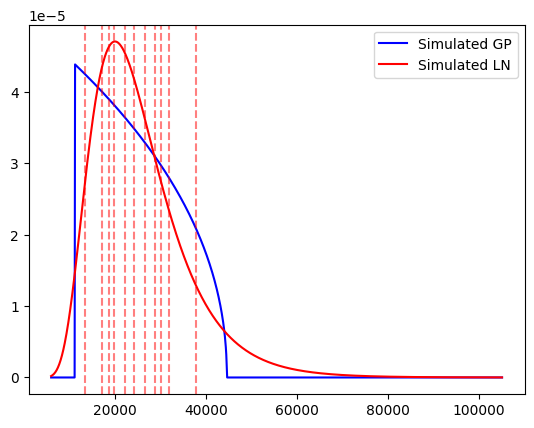

In [44]:
law_gp=genpareto(loc=post_loc_gp,scale=post_scale_gp,c=post_shape_gp)
law_ln=lognorm(s=post_shape_ln, scale=np.exp(post_scale_ln),loc=post_loc_ln)
law_p2=pareto2(loc=post_loc_p2,scale=post_scale_p2,shape=post_shape_p2)

plt.scatter(P,Q_contes,color="green",label = "Data")
plt.scatter(P,law_ln.ppf(P),label="Simulated LN",color="red",alpha=.5)
plt.scatter(P,law_gp.ppf(P),label = "Simulated GP",color="blue",alpha=.5)
plt.legend()
plt.show()
x=np.linspace(min(law_gp.ppf(.0001),law_ln.ppf(.0001)),max(law_gp.ppf(.9999),law_ln.ppf(.9999)),1000)
plt.plot(x,law_gp.pdf(x),label = "Simulated GP",color="blue")
plt.plot(x,law_ln.pdf(x),label="Simulated LN",color="red")
for q in Q_contes:
    plt.axvline(q,color="red",alpha=.5,linestyle="--")
    
plt.legend()

In [57]:
BF_contes=BF_Bridge_Quantile(Y_ln,Y_p2,theta_ln,theta_p2,llike_lognormal,llike_pareto2,BF_init=1,epsilon=.001,n=100)

/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  


1. Mean llike1(y1|theta1) = -31660.17003378013 Mean llike2(y1|theta1) = nan
1. Mean llike1(y2|theta2) = -32039.114958392493 Mean llike2(y2|theta2) = -31653.133667856822
1. Numerator = 4.03E-110 Denominator = NAN BF = nan


In [ ]:
1165.263813446751 79074.25510602815 -2.2629390140369523

In [58]:
post_loc_ln,post_mean_ln,post_std_ln = theta_ln.T
post_scale_ln = np.log((post_mean_ln - post_loc_ln)**2/np.sqrt((post_mean_ln - post_loc_ln)**2+post_std_ln**2)),
post_shape_ln = np.sqrt(np.log(1+post_std_ln**2/(post_mean_ln - post_loc_ln)**2))

post_scale_ln_gp = (post_mean_ln - post_loc_ln)/2+(post_mean_ln - post_loc_ln)**3/(2*post_std_ln**2)
post_shape_ln_gp = 1/2-(post_mean_ln - post_loc_ln)**2/(2*post_std_ln**2)

post_scale_ln_p2 = (post_mean_ln - post_loc_ln)*(post_std_ln**2+(post_mean_ln - post_loc_ln)**2)/(post_std_ln**2-(post_mean_ln - post_loc_ln)**2)
post_shape_ln_p2 = 2*post_std_ln**2/(post_std_ln**2-(post_mean_ln - post_loc_ln)**2)

print("Mean LN\nloc = {} mean = {} std = {}\nfor LN:\nloc = {} scale = {} shape = {}\nfor GP:\nloc = {} scale = {} shape = {}\nfor P2:\nloc = {} scale = {} shape = {}".format(np.mean(post_loc_ln),np.mean(post_mean_ln),np.mean(post_std_ln),np.mean(post_loc_ln),np.mean(post_scale_ln),np.mean(post_shape_ln),np.mean(post_loc_ln),np.mean(post_scale_ln_gp),np.mean(post_shape_ln_gp),np.mean(post_loc_ln),np.mean(post_scale_ln_p2),np.mean(post_shape_ln_p2)))

Mean LN
loc = 1195.6914422772284 mean = 25510.052179272563 std = 10492.65312127582
for LN:
loc = 1195.6914422772284 scale = 10.013243039958255 shape = 0.4133038597722133
for GP:
loc = 1195.6914422772284 scale = 77558.97379491334 shape = -2.1887566520707247
for P2:
loc = 1195.6914422772284 scale = -35459.17059782381 shape = -0.4585970272892444


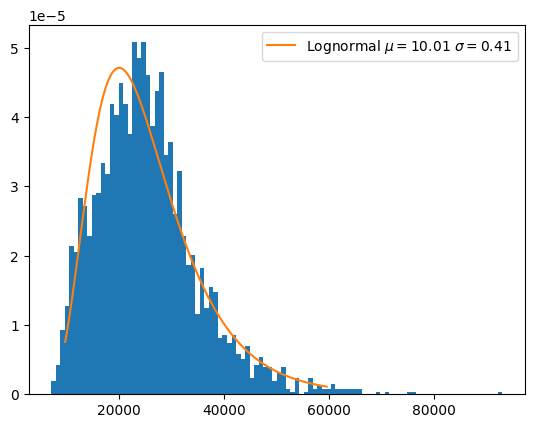

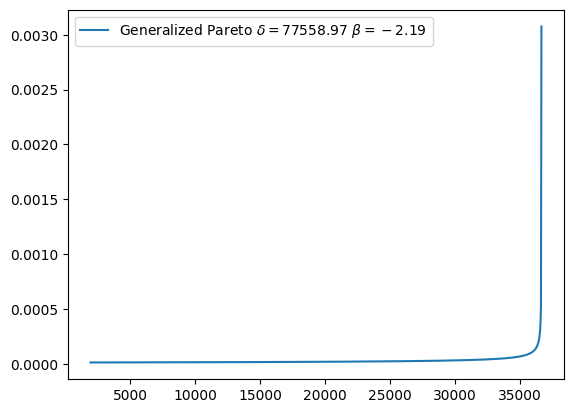

In [46]:
law_ln = lognorm(loc = np.mean(post_loc_ln), scale = np.mean(np.exp(post_scale_ln)), s = np.mean(post_shape_ln))
plt.hist(Y_ln[0],bins=100,density=True);
x = np.linspace(law_ln.ppf(.01),law_ln.ppf(.99),1000)
plt.plot(x,law_ln.pdf(x),label="Lognormal $\mu = {:.2f}$ $\sigma = {:.2f}$".format(np.mean(post_scale_ln),np.mean(post_shape_ln)))
plt.legend()
plt.show()
law_ln_gp=genpareto(loc=np.mean(post_loc_ln),scale=np.mean(post_scale_ln_gp),c=np.mean(post_shape_ln_gp))
x = np.linspace(law_ln_gp.ppf(.01),law_ln_gp.ppf(.99),1000)
plt.plot(x,law_ln_gp.pdf(x),label="Generalized Pareto $\delta = {:.2f}$ $\\beta = {:.2f}$".format(np.mean(post_scale_ln_gp),np.mean(post_shape_ln_gp)))
plt.legend()

In [59]:
post_loc_p2, post_mean_p2, post_std_p2 = theta_p2.T
post_scale_p2 = (post_mean_p2 - post_loc_p2)*(post_std_p2**2+(post_mean_p2 - post_loc_p2)**2)/(post_std_p2**2-(post_mean_p2 - post_loc_p2)**2)
post_shape_p2 = 2*post_std_p2**2/(post_std_p2**2-(post_mean_p2 - post_loc_p2)**2)

post_scale_p2_ln = (post_mean_p2 - post_loc_p2)/2+(post_mean_p2 - post_loc_p2)**3/(2*post_std_p2**2)
post_shape_p2_ln = 1/2-(post_mean_p2 - post_loc_p2)**2/(2*post_std_p2**2)

print("Mean P2\nloc = {} mean = {} std = {}\nfor P2:\nloc = {} scale = {} shape = {}\nfor LN:\nloc = {} scale = {} shape = {}".format(np.mean(post_loc_p2),np.mean(post_mean_p2),np.mean(post_std_p2),np.mean(post_loc_p2),np.mean(post_scale_p2),np.mean(post_shape_p2),np.mean(post_loc_p2),np.mean(post_scale_p2_ln),np.mean(post_shape_p2_ln)))

Mean P2
loc = 13505.26756318654 mean = 27626.059801484967 std = 14150.996189618889
for P2:
loc = 13505.26756318654 scale = 60550651.49529093 shape = 4292.377710960062
for LN:
loc = 13505.26756318654 scale = 14090.77945398756 shape = 0.0021229232046605945


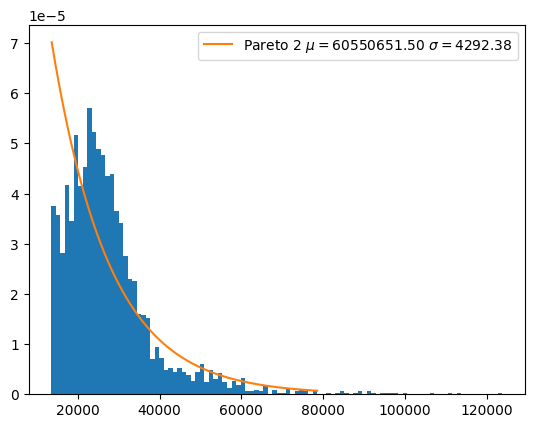

/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/numpy/core/function_base.py:134: RuntimeWarning: invalid value encountered in double_scalars
  delta = stop - start
/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1870: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


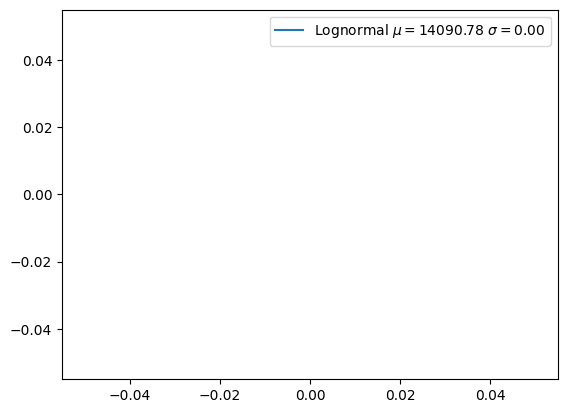

In [48]:
law_p2 = pareto2(loc = np.mean(post_loc_p2), scale = np.mean(post_scale_p2), shape = np.mean(post_shape_p2))
plt.hist(Y_p2[0],bins=100,density=True);
x = np.linspace(law_p2.ppf(.01),law_p2.ppf(.99),1000)
plt.plot(x,law_p2.pdf(x),label="Pareto 2 $\mu = {:.2f}$ $\sigma = {:.2f}$".format(np.mean(post_scale_p2),np.mean(post_shape_p2)))
plt.legend()
plt.show()

law_p2_ln = lognorm(loc = np.mean(post_loc_p2), scale = np.mean(np.exp(post_scale_p2_ln)), s = np.mean(post_shape_p2_ln))
#plt.hist(Y_p2[0],bins=100,density=True);
x = np.linspace(law_p2_ln.ppf(.01),law_p2_ln.ppf(.99),1000)
plt.plot(x,law_p2_ln.pdf(x),label="Lognormal $\mu = {:.2f}$ $\sigma = {:.2f}$".format(np.mean(post_scale_p2_ln),np.mean(post_shape_p2_ln)))
plt.legend()

In [55]:
post_loc_gp

11188.210779374778

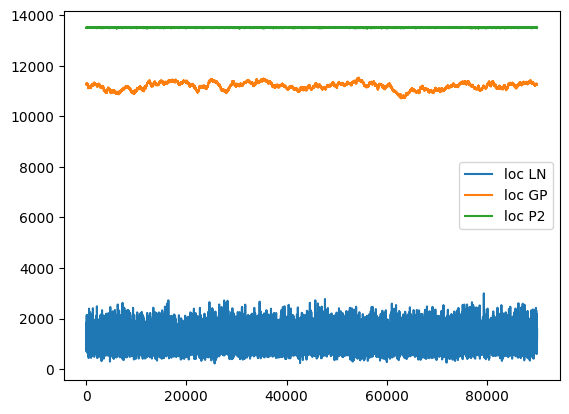

In [62]:
plt.plot(post_loc_ln,label="loc LN")
plt.plot(post_loc_gp,label="loc GP")
plt.plot(post_loc_p2,label="loc P2")
plt.legend()

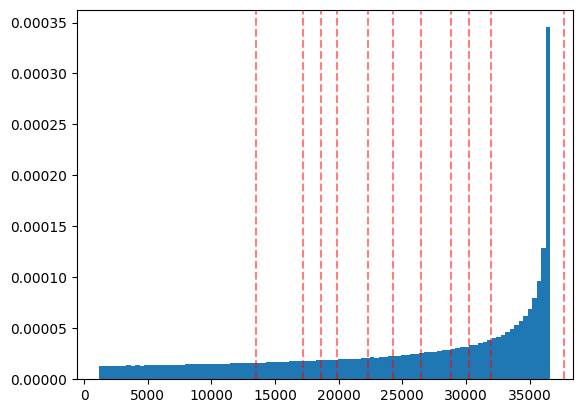

In [862]:
test = law_ln_gp.rvs(1000000)
np.mean(test),np.std(test)
plt.hist(test,bins=100,density=True);
for q in Q_contes:
    plt.axvline(q,color="red",alpha=.5,linestyle="--")

In [60]:
post_loc_gp,post_mean_gp,post_std_gp = theta_gp.T

post_scale_gp = (post_mean_gp - post_loc_gp)/2+(post_mean_gp - post_loc_gp)**3/(2*post_std_gp**2)
shape__gp = 1/2-(post_mean_gp - post_loc_gp)**2/(2*post_std_gp**2)

post_scale_gp_ln = np.log((post_mean_gp - post_loc_gp)**2/np.sqrt((post_mean_gp - post_loc_gp)**2+post_std_gp**2)),
post_shape_gp_ln = np.sqrt(np.log(1+post_std_gp**2/(post_mean_gp - post_loc_gp)**2))



print("Mean GP\nloc = {} mean = {} std = {}\nfor GP:\nloc = {} scale = {} shape = {}\nfor LN:\nloc = {} scale = {} shape = {}".format(np.mean(post_loc_gp),np.mean(post_mean_gp),np.mean(post_std_gp),np.mean(post_loc_gp),np.mean(post_scale_gp),np.mean(post_shape_gp),np.mean(post_loc_gp),np.mean(post_scale_gp_ln),np.mean(post_shape_gp_ln)))

Mean GP
loc = 11188.210779374778 mean = 24725.629329576917 std = 8804.571548124099
for GP:
loc = 11188.210779374778 scale = 22779.334805607115 shape = -0.6820211940000938
for LN:
loc = 11188.210779374778 scale = 9.336684504688808 shape = 0.593989236806936


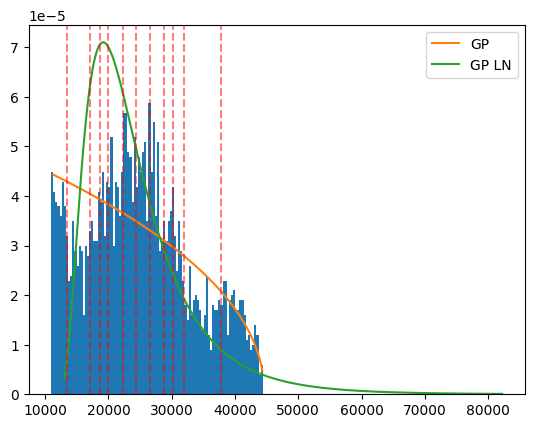

In [880]:
law_gp = genpareto(loc = np.mean(post_loc_gp), scale = np.mean(post_scale_gp), c = np.mean(post_shape_gp))
plt.hist(Y_gp[-1],bins=100,density=True);
x = np.linspace(law_gp.ppf(.001),law_gp.ppf(.999),1000)
plt.plot(x,law_gp.pdf(x),label="GP")
law_gp_ln=lognorm(loc=np.mean(post_loc_gp),scale=np.exp(np.mean(post_scale_gp_ln)),s=np.mean(post_shape_gp_ln))
x = np.linspace(law_gp_ln.ppf(.001),law_gp_ln.ppf(.999),1000)
plt.plot(x,law_gp_ln.pdf(x),label="GP LN")
plt.legend()
for q in Q_contes:
    plt.axvline(q,color="red",alpha=.5,linestyle="--")


In [872]:
test= law_gp_ln.rvs(1000000)
np.mean(test),np.std(test)


(11271.868702908036, 7.269155598212091)